In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import torch
import time
import pickle
import seaborn as sns
import scipy.stats

In [2]:
import matplotlib.pyplot as plt

SMALL_SIZE =  14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [3]:
sys.path.append('/global/u2/v/vboehm/codes/SIG_GIS/')
from sig_gis import *
from sig_gis.GIS import *

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
classes = {2:'GAL', 1:'QSO', 0:'STAR'}

In [6]:
plotpath = '/global/homes/v/vboehm/codes/SDSS_PAE/figures'

In [7]:
RUN             = '1'
EPOCHS          = 40

seeds           = {'1':512, '2':879, '3':9981, '4': 20075, '5': 66, '6': 276, '7': 936664}

conditional     = False
cond_on         = 'type'

root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.1
max_z           = 0.36
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)
label_2         = label_+'_10_fully_connected_mean_div'

if conditional:
    label_2='conditional_%s'%cond_on+label_2
    
upsampling      = 'SMOTE'
fac             = 10

In [8]:
decoded = {}
masked  = {}

In [9]:
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_AE2_%s_RUN%s.npy'%(label_2, RUN)), allow_pickle=True)
decoded['train'],decoded['valid'], decoded['test'], mean, std  = np.load(os.path.join(root_decoded,'decoded_%s.npy'%(label_2)), allow_pickle=True)

In [10]:
train,valid,test,le = pickle.load(open(os.path.join(root_model_data,'combined_%s.pkl'%label_),'rb'))

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.22.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [11]:
encoded_train    = encoded_train[train['class']==2]
decoded['train'] = decoded['train'][train['class']==2]

In [12]:
encoded_test     = encoded_test[test['class']==2]
decoded['test']  = decoded['test'][test['class']==2]


In [13]:
encoded_valid    = encoded_valid[valid['class']==2]
decoded['valid'] = decoded['valid'][valid['class']==2]


In [14]:
for kk in train.keys():
    if kk not in ['class','mean', 'std']:
        train[kk]=train[kk][train['class']==2]
train['class']=train['class'][train['class']==2]   

for kk in valid.keys():
    if kk not in ['class','mean', 'std']:
        valid[kk]=valid[kk][valid['class']==2]
valid['class']=valid['class'][valid['class']==2]   



In [15]:
for kk in test.keys():
    if kk not in ['class','mean', 'std', 'SN']:
        print(kk, test[kk].shape, (test['class']==2).shape)
        test[kk]=test[kk][test['class']==2]
test['class']=test['class'][test['class']==2]   

spec (7692, 1000, 1) (7692,)
mask (7692, 1000, 1) (7692,)
noise (7692, 1000, 1) (7692,)
z (7692,) (7692,)
RA (7692,) (7692,)
DE (7692,) (7692,)
subclass (7692,) (7692,)
MJD (7692,) (7692,)
plate (7692,) (7692,)
fiber (7692,) (7692,)


In [16]:


classes = np.load(os.path.join('/global/cscratch1/sd/vboehm/SDSSOutlier/results','new_labels_%s_RUN%s.npy'%(label_2, RUN)),allow_pickle=True)
train['subclass'], valid['subclass'], test['subclass'] = classes[0].astype(int), classes[1].astype(int), classes[2].astype(int)

1397 53119 392 0.33146468


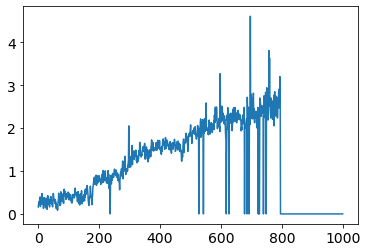

In [17]:

plt.plot(train['spec'][0])

print(train['plate'][0], train['MJD'][0], train['fiber'][0], train['z'][0])

617 52072 618 0.33501092


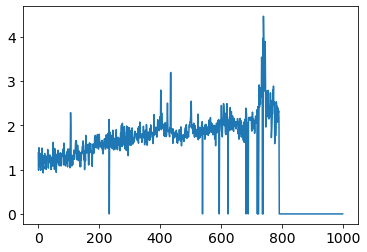

In [18]:
ii=1
plt.plot(test['spec'][ii])

print(test['plate'][ii], test['MJD'][ii], test['fiber'][ii], test['z'][ii])

In [19]:
label, count = np.unique(train['subclass'],return_counts=True)
print(le.inverse_transform(label))
print(count)

[b'' b'AGN' b'AGN BROADLINE' b'BROADLINE' b'STARBURST'
 b'STARBURST BROADLINE' b'STARFORMING' b'STARFORMING BROADLINE']
[40789  2098   214   205  3658    70  2225   183]


In [20]:
train_x = torch.Tensor(np.squeeze(encoded_train)).to(device) 
train_y = torch.Tensor(train['subclass']).to(torch.long).to(device)

valid_x = torch.Tensor(np.squeeze(encoded_valid)).to(device) 
valid_y = torch.Tensor(valid['subclass']).to(torch.long).to(device)

test_x = torch.Tensor(np.squeeze(encoded_test)).to(device) 
test_y = torch.Tensor(test['subclass']).to(torch.long).to(device)

In [21]:
np.unique(train['class'])

array([2])

In [22]:
model = torch.load(os.path.join(root_models,'conditional_SINF_%s_%s_%d_AE_2_inpainted_denoised'%(label_2,upsampling,fac)))

In [23]:
dens_train     = model.evaluate_density(train_x,train_y).cpu().numpy()
dens_valid     = model.evaluate_density(valid_x,valid_y).cpu().numpy()
dens_test      = model.evaluate_density(test_x,test_y).cpu().numpy()

In [24]:
masked['train'] = np.ma.array(np.squeeze(train['spec']),mask=~np.squeeze(train['mask'].astype('bool')))
masked['valid'] = np.ma.array(np.squeeze(valid['spec']),mask=~np.squeeze(valid['mask'].astype('bool')))
masked['test']  = np.ma.array(np.squeeze(test['spec']),mask=~np.squeeze(test['mask'].astype('bool')))

In [25]:
clip =1 

In [26]:
df_train         = pd.DataFrame.from_dict(dict((k,train[k]) for k in ('MJD','fiber','plate','subclass','class', 'RA', 'DE') if k in train))
df_train['logp'] = dens_train
df_train['mask_fracs'] = np.sum(~train['mask'].astype('bool'),axis=1)/1000
df_train['z']    = train['z']
noise            = np.ma.array(np.squeeze(train['noise']),mask=~np.squeeze(train['mask'].astype('bool')))
masked_array     = np.ma.array(np.squeeze(train['spec'])-decoded['train'],mask=~np.squeeze(train['mask'].astype('bool')))
df_train['recon_error_std'] = np.ma.std(masked_array**2*noise,axis=1)

df_train['recon_error'] = np.ma.mean(np.ma.clip(masked_array**2*noise,a_min=np.zeros_like(df_train['recon_error_std'].to_numpy())[:,None],a_max=clip*df_train['recon_error_std'].to_numpy()[:,None]),axis=1)

df_train['max_recon_error'] = np.ma.max(np.ma.array(np.squeeze(train['spec'])-decoded['train'],mask=~np.squeeze(train['mask'].astype('bool')))**2*noise,axis=1)
df_train = df_train.reset_index()

In [27]:
df_test         = pd.DataFrame.from_dict(dict((k,test[k]) for k in ('MJD','fiber','plate','subclass', 'RA', 'DE') if k in test))
df_test['logp'] = dens_test
df_test['mask_fracs'] = np.sum(~test['mask'].astype('bool'),axis=1)/1000
df_test['z']    = test['z']
noise           = np.ma.array(np.squeeze(test['noise']),mask=~np.squeeze(test['mask'].astype('bool')))
df_test['recon_error_std'] = np.ma.std(np.ma.array(np.squeeze(test['spec'])-decoded['test'],mask=~np.squeeze(test['mask'].astype('bool')))**2*noise,axis=1)

df_test['recon_error'] = np.ma.mean(np.ma.clip(np.ma.array(np.squeeze(test['spec'])-decoded['test'],\
mask=~np.squeeze(test['mask'].astype('bool')))**2*noise,a_min=np.zeros_like(df_test['recon_error_std'].to_numpy())[:,None],a_max=clip*df_test['recon_error_std'].to_numpy()[:,None]),axis=1)

df_test['max_recon_error'] = np.ma.max(np.ma.array(np.squeeze(test['spec'])-decoded['test'],mask=~np.squeeze(test['mask'].astype('bool')))**2*noise,axis=1)
df_test = df_test.reset_index()

In [28]:
df_valid         = pd.DataFrame.from_dict(dict((k,valid[k]) for k in ('MJD','fiber','plate','subclass', 'RA', 'DE') if k in valid))
df_valid['logp'] = dens_valid
df_valid['mask_fracs'] = np.sum(~valid['mask'].astype('bool'),axis=1)/1000
df_valid['z']    = valid['z']
noise            = np.ma.array(np.squeeze(valid['noise']),mask=~np.squeeze(valid['mask'].astype('bool')))
df_valid['recon_error_std'] = np.ma.std(np.ma.array(np.squeeze(valid['spec'])-decoded['valid'],mask=~np.squeeze(valid['mask'].astype('bool')))**2*noise,axis=1)

df_valid['recon_error'] = np.ma.mean(np.ma.clip(np.ma.array(np.squeeze(valid['spec'])-decoded['valid'],\
mask=~np.squeeze(valid['mask'].astype('bool')))**2*noise,a_min=np.zeros_like(df_valid['recon_error_std'].to_numpy())[:,None],a_max=clip*df_valid['recon_error_std'].to_numpy()[:,None]),axis=1)

df_valid['max_recon_error'] = np.ma.max(np.ma.array(np.squeeze(valid['spec'])-decoded['valid'],mask=~np.squeeze(valid['mask'].astype('bool')))**2*noise,axis=1)
df_valid = df_valid.reset_index()

In [29]:
df_train['fiber'][0]

392

In [30]:
import sklearn.linear_model
import sklearn.kernel_ridge
LRl = sklearn.linear_model.LinearRegression()

In [31]:
p=1

In [32]:
def fit_regression(data_,class_):
    ind = (data_['subclass']==class_)
    LRl.fit((data_['mask_fracs'])[ind,None],data_['logp'][ind,None])
    ind = (data_['subclass']==class_)
    h =plt.hist2d(data_['mask_fracs'][ind], data_['logp'][ind], range=[[0.1,0.36],[-50,50]], bins=[40,40])
    plt.plot(data_['mask_fracs'][ind,None],LRl.predict(data_['mask_fracs'][ind,None]), ls='',marker='.')
    plt.show()
    return ind, data_['logp'][ind, None]-LRl.predict(data_['mask_fracs'][ind, None]), LRl

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


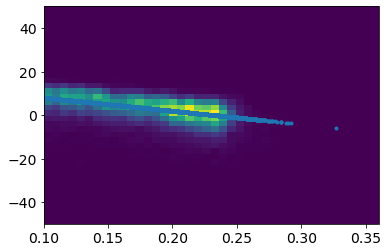

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


(array([], dtype=int64),)


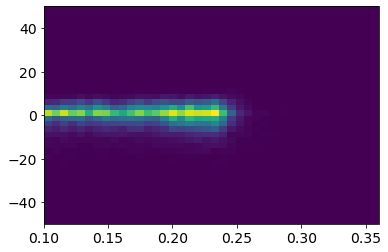

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


(array([], dtype=int64),)


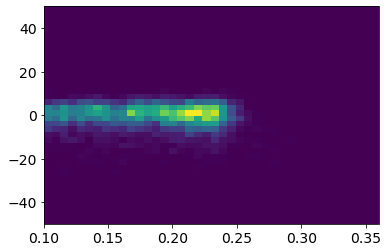

(array([], dtype=int64),)


/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


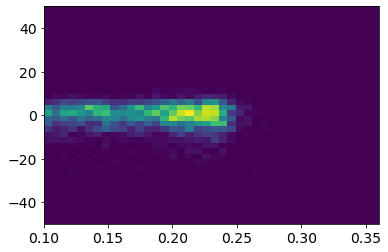

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


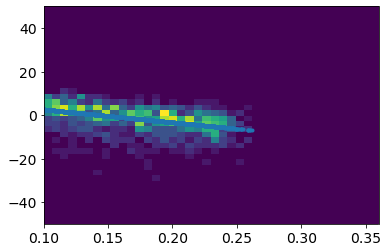

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


(array([], dtype=int64),)


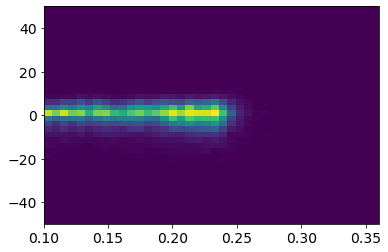

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


(array([], dtype=int64),)


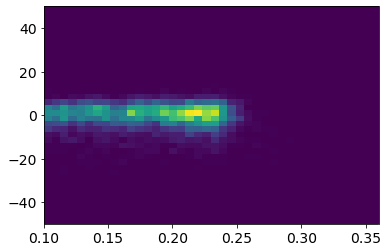

(array([], dtype=int64),)


/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


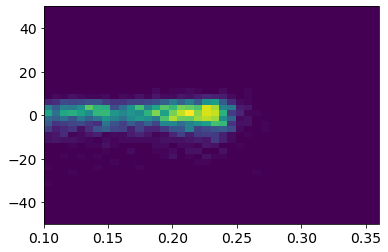

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


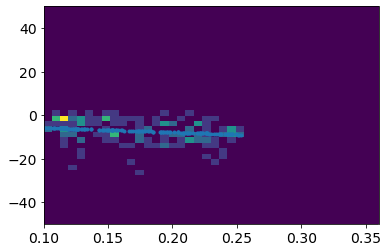

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


(array([], dtype=int64),)


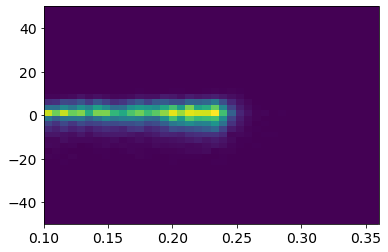

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


(array([], dtype=int64),)


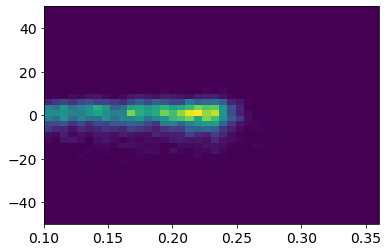

(array([], dtype=int64),)


/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


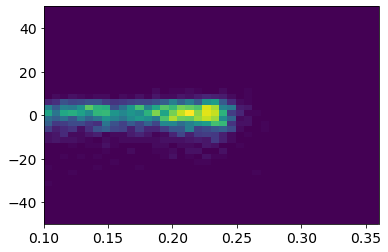

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


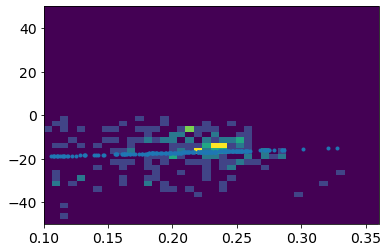

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


(array([], dtype=int64),)


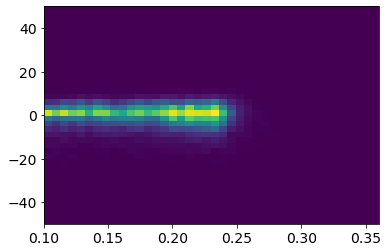

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


(array([], dtype=int64),)


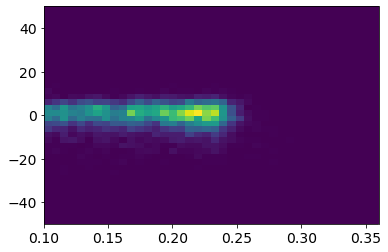

(array([], dtype=int64),)


/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


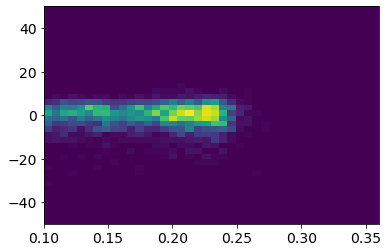

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


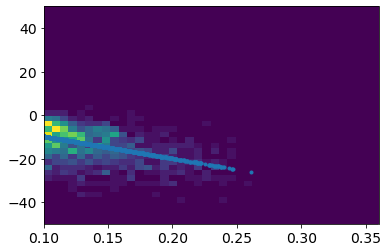

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


(array([], dtype=int64),)


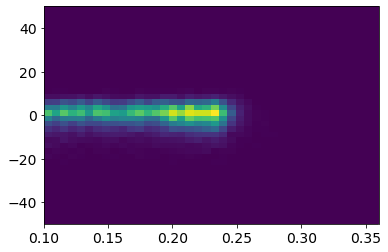

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


(array([], dtype=int64),)


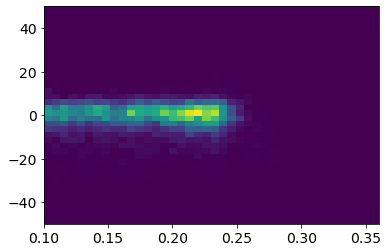

(array([], dtype=int64),)


/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


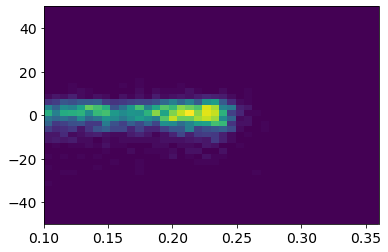

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


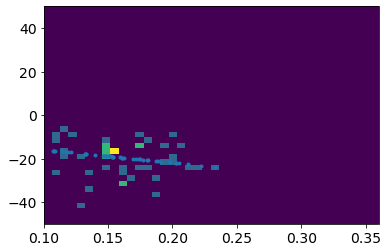

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


(array([], dtype=int64),)


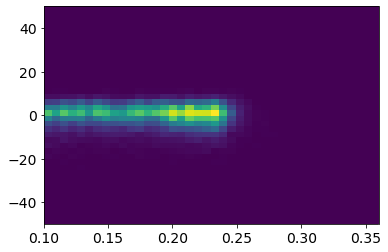

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


(array([], dtype=int64),)


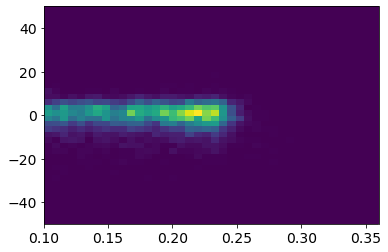

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


(array([], dtype=int64),)


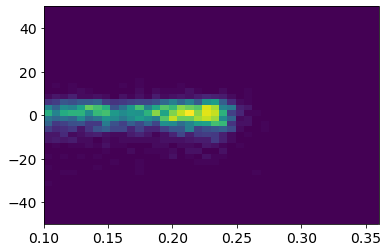

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


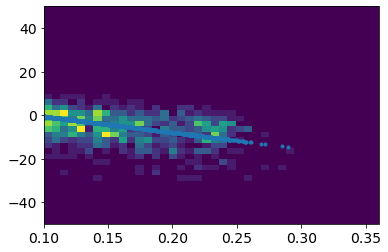

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


(array([], dtype=int64),)


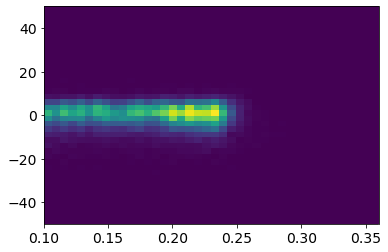

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


(array([], dtype=int64),)


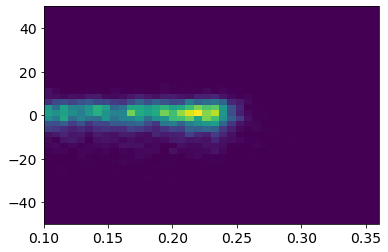

(array([], dtype=int64),)


/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


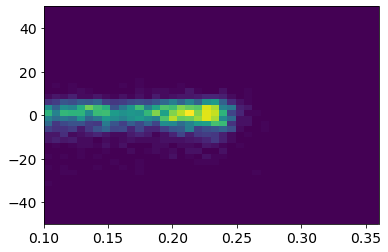

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


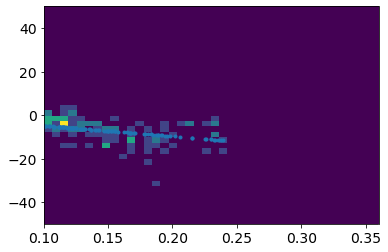

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


(array([], dtype=int64),)


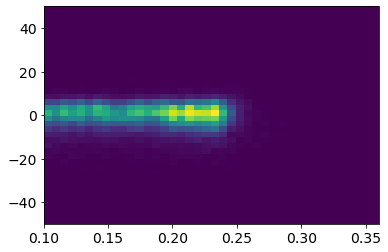

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


(array([], dtype=int64),)


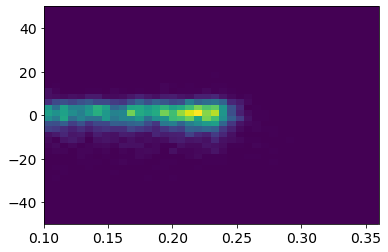

(array([], dtype=int64),)


/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


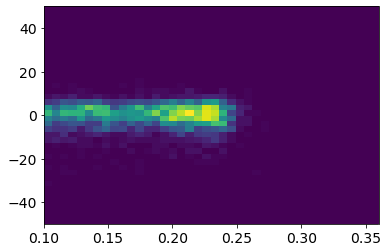

In [33]:
for ii in range(8):
    for jj, df_ in enumerate([df_train, df_valid, df_test]):
        if jj ==0:
            if ii==0:
                df_['logp_corr'] = np.zeros((len(df_)))
            ind, val, LRl = fit_regression(df_,ii)
        else:
            ind = (df_['subclass']==ii)
            val = df_['logp'][ind,None]-LRl.predict(df_['mask_fracs'][ind,None])
        print(np.where(np.isnan(val[:,0])))
        df_.loc[ind.to_numpy(), 'logp_corr'] = val[:,0]
        h =plt.hist2d(df_['mask_fracs'], df_['logp_corr'], range=[[0.1,0.36],[-50,50]], bins=[40,40])
        plt.show()

In [34]:
# for ii in range(7):
#     for jj, df_ in enumerate([df_train, df_valid, df_test]):
#         ind = (df_['subclass']==ii)        
#         h =plt.hist2d(df_['mask_fracs'][ind], df_['logp_corr'][ind], range=[[0.1,0.36],[-50,50]], bins=[40,40])
#         plt.show()

In [35]:
corr, _= scipy.stats.pearsonr(df_train['mask_fracs'],-df_train['logp'])
print(corr)
corr, _= scipy.stats.pearsonr(df_train['mask_fracs'],df_train['logp_corr'])
print(corr)
corr, _= scipy.stats.pearsonr(df_train['mask_fracs'],df_train['z'])
print(corr)
corr, _= scipy.stats.pearsonr(-df_train['logp'],df_train['z'])
print(corr)

0.4309721307847204
3.937822290467352e-16
0.9933826098481904
0.4114374790932246


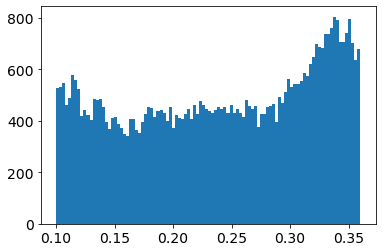

In [36]:
_ = plt.hist(df_train['z'],bins=100)

Text(0.5, 0, 'mask_fracs')

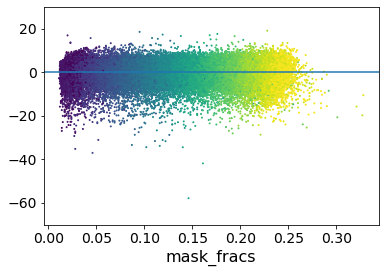

In [37]:
plt.scatter(df_train['mask_fracs'],df_train['logp_corr'], s=1, c=df_train['z'])
plt.axhline(0)
plt.ylim(-70,30)
plt.xlabel('mask_fracs')

Text(0, 0.5, 'logp')

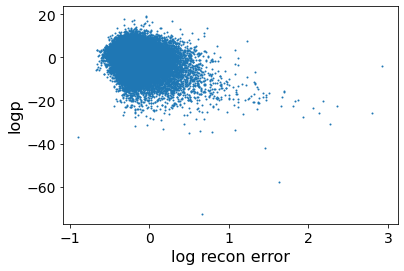

In [38]:
plt.scatter(np.log(df_train['recon_error'][df_train['logp_corr']>-100]),df_train['logp_corr'][df_train['logp_corr']>-100],s=1)
plt.xlabel('log recon error')
plt.ylabel('logp')

In [39]:
df_train['logp_ranking'] = np.argsort(df_train['logp_corr'])
df_train['recon_error_ranking'] = np.argsort(-df_train['recon_error'])

In [40]:
df_valid['logp_ranking'] = np.argsort(df_valid['logp_corr'])
df_valid['recon_error_ranking'] = np.argsort(-df_valid['recon_error'])

In [41]:
df_test['logp_ranking'] = np.argsort(df_test['logp_corr'])
df_test['recon_error_ranking'] = np.argsort(-df_test['recon_error'])

In [42]:
for df in [df_test, df_train, df_valid]:
    df.drop(columns=['logp'],inplace=True)
    df.rename(columns={'logp_corr':'logp'},inplace=True)

In [43]:
df_train.to_csv(os.path.join('/global/cscratch1/sd/vboehm/SDSSOutlier/results/','training_set_no_QSO_relabeled.csv'))
df_valid.to_csv(os.path.join('/global/cscratch1/sd/vboehm/SDSSOutlier/results/','validation_set_no_QSO_relabeled.csv'))
df_test.to_csv(os.path.join('/global/cscratch1/sd/vboehm/SDSSOutlier/results/','test_set_no_QSO_relabeled.csv'))

In [44]:
plt.scatter(np.log(df_train['max_recon_error'][df_train['logp']>-100]),-df_train['logp_corr'][df_train['logp_corr']>-100],s=1)

KeyError: 'logp_corr'

In [45]:
scipy.stats.pearsonr(np.log(df_train['recon_error']),df_train['logp_corr'])

KeyError: 'logp_corr'

In [46]:
#plt.scatter(encoded_train[:,0], encoded_train[:,1])
#plt.scatter(encoded_train[:,0][df_train['subclass']==6], encoded_train[:,1][df_train['subclass']==6], s=1)
plt.figure(figsize=(9,9))
plt.scatter(encoded_train[:,0][(df_train['subclass']==6)&(df_train['logp_corr']>-100)], encoded_train[:,1][(df_train['subclass']==6)&(df_train['logp_corr']>-100)], c=df_train['logp_corr'][(df_train['subclass']==6)&(df_train['logp_corr']>-100)], s=3)
plt.scatter(encoded_train[:,0][(df_train['subclass']==6)&(df_train['logp_corr']>-100)], encoded_train[:,1][(df_train['subclass']==6)&(df_train['logp_corr']>-100)], c=df_train['logp_corr'][(df_train['subclass']==6)&(df_train['logp_corr']>-100)], s=3)


KeyError: 'logp_corr'

<Figure size 648x648 with 0 Axes>

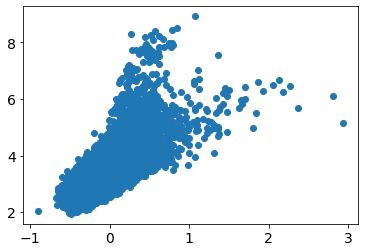

In [47]:
plt.scatter(np.log(df_train['recon_error']),np.log(df_train['max_recon_error']))

In [ ]:
plt.scatter(df_train['mask_fracs'],np.log(df_train['recon_error']))

In [ ]:
plt.plot(masked['valid'][0])
plt.plot(masked['test'][0])

In [ ]:
res=[]
for spec in decoded['test']:
    res.append(np.mean((decoded['valid'][0]-spec)**2))

In [ ]:
for spec in test['spec']:
    res.append(np.mean((valid['spec'][0]-spec)**2))

In [ ]:
df_valid['mask_fracs'][np.where(np.isnan(df_valid['logp_corr']))[0]]

In [ ]:
for mm in range(8):
    for data, name, df in zip([test],['test'],[df_test]):
        ind = np.where(data['subclass']==mm)[0]

        dens            = -df['recon_error'].iloc[ind].to_numpy()

        ind_ood         = np.argsort(dens)
        dens_sorted     = dens[ind_ood]

        cum, bins, _      = plt.hist(-dens_sorted,bins=500,density=True, cumulative=True, log=False, color='navy')
        plt.xlabel('recon error')
        plt.ylabel('cum. normalized counts')
        plt.savefig(os.path.join(plotpath,'relabeled/recon_error/','recon_error_hist_%s_%s.pdf'%(name,(le.inverse_transform([mm])[0]).decode('utf8'))), bbox_inches='tight')
        plt.show()
        plt.close()

        outliers_decoded  = decoded[name][ind][ind_ood]
        outliers_input    = masked[name][ind][ind_ood]

        wlmin, wlmax      = (3388,8318)
        fixed_num_bins    = 1000
        wl_range          = (np.log10(wlmin),np.log10(wlmax))
        new_wl            = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

        print('Anomalous Spectra', name, mm)
        fi, ax = plt.subplots(6,2,figsize=(18,20))
        ax = ax.flatten()
        for ii in range(min(len(dens_sorted),12)):
            percentile = scipy.stats.percentileofscore(dens_sorted, dens_sorted[ii], kind='rank')
            ax[ii].set_title('%s, %d, %d, %d, z=%.2f'%(classes[data['class'][ind][ind_ood][ii]], data['MJD'][ind][ind_ood][ii],data['plate'][ind][ind_ood][ii],data['fiber'][ind][ind_ood][ii],data['z'][ind][ind_ood][ii]))
            ax[ii].plot(new_wl[1:],outliers_input[ii],label='recon error=%.1f, percentile=%.2e'%(-dens_sorted[ii],percentile), color='black')
            ax[ii].vlines( x=new_wl[1:][np.squeeze(~data['mask'][ind][ind_ood][ii].astype(bool))], ymin=0,ymax=max(data['spec'][ind][ind_ood][ii]), color='steelblue',alpha=0.3)
            ax[ii].plot(new_wl[1:],outliers_decoded[ii], label='reconstruction',ls='-', color='orange', lw=2)

            ax[ii].legend()
            if ii in [10,11]:
                ax[ii].set_xlabel(r'restframe $\lambda$ [nm]')
            if ii%2==0:
                ax[ii].set_ylabel(r'standardized flux')        
        plt.tight_layout()
        plt.savefig(os.path.join(plotpath,'relabeled/recon_error/','recon_error_outliers_class_%s_%s.pdf'%(name,(le.inverse_transform([mm])[0]).decode('utf8'))), bbox_inches='tight')
        plt.show()
        plt.close()

        print('Most normal Spectra', name, mm)
        fi, ax = plt.subplots(6,2,figsize=(18,20),sharex=True)
        ax = ax.flatten()
        for nn, ii in enumerate(range(len(ind_ood)-min(len(dens_sorted),12),len(ind_ood))):
            percentile = scipy.stats.percentileofscore(dens_sorted, dens_sorted[ii], kind='rank')
            ax[nn].set_title('%s, %d, %d, %d, z=%.2f'%(classes[data['class'][ind][ind_ood][ii]], data['MJD'][ind][ind_ood][ii],data['plate'][ind][ind_ood][ii],data['fiber'][ind][ind_ood][ii],data['z'][ind][ind_ood][ii]))
            ax[nn].plot(new_wl[1:],outliers_input[ii],label='recon error=%.1f, percentile=%.2e'%(-dens_sorted[ii],percentile), color='black')
            ax[nn].vlines( x=new_wl[1:][np.squeeze(~data['mask'][ind][ind_ood][ii].astype(bool))], ymin=min(0,min(data['spec'][ind][ind_ood][ii])),ymax=max(data['spec'][ind][ind_ood][ii]), color='steelblue',alpha=0.3, label='mask')
            ax[nn].plot(new_wl[1:],outliers_decoded[ii], label='reconstruction',ls='-', color='orange', lw=2)
            ax[nn].legend()
            if nn in [10,11]:
                ax[nn].set_xlabel(r'restframe $\lambda$ [nm]')
            if nn%2==0:
                ax[nn].set_ylabel(r'standardized flux')                
        plt.tight_layout()
        plt.savefig(os.path.join(plotpath,'relabeled/recon_error/','recon_error_most_common_class_%s_%s.pdf'%(name,(le.inverse_transform([mm])[0]).decode('utf8'))), bbox_inches='tight')
        plt.show()
        plt.close()





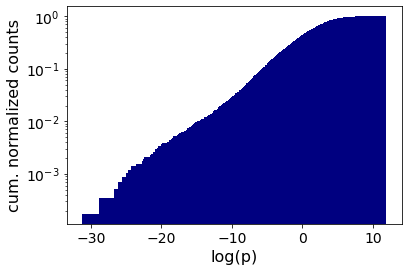

Anomalous Spectra test 0


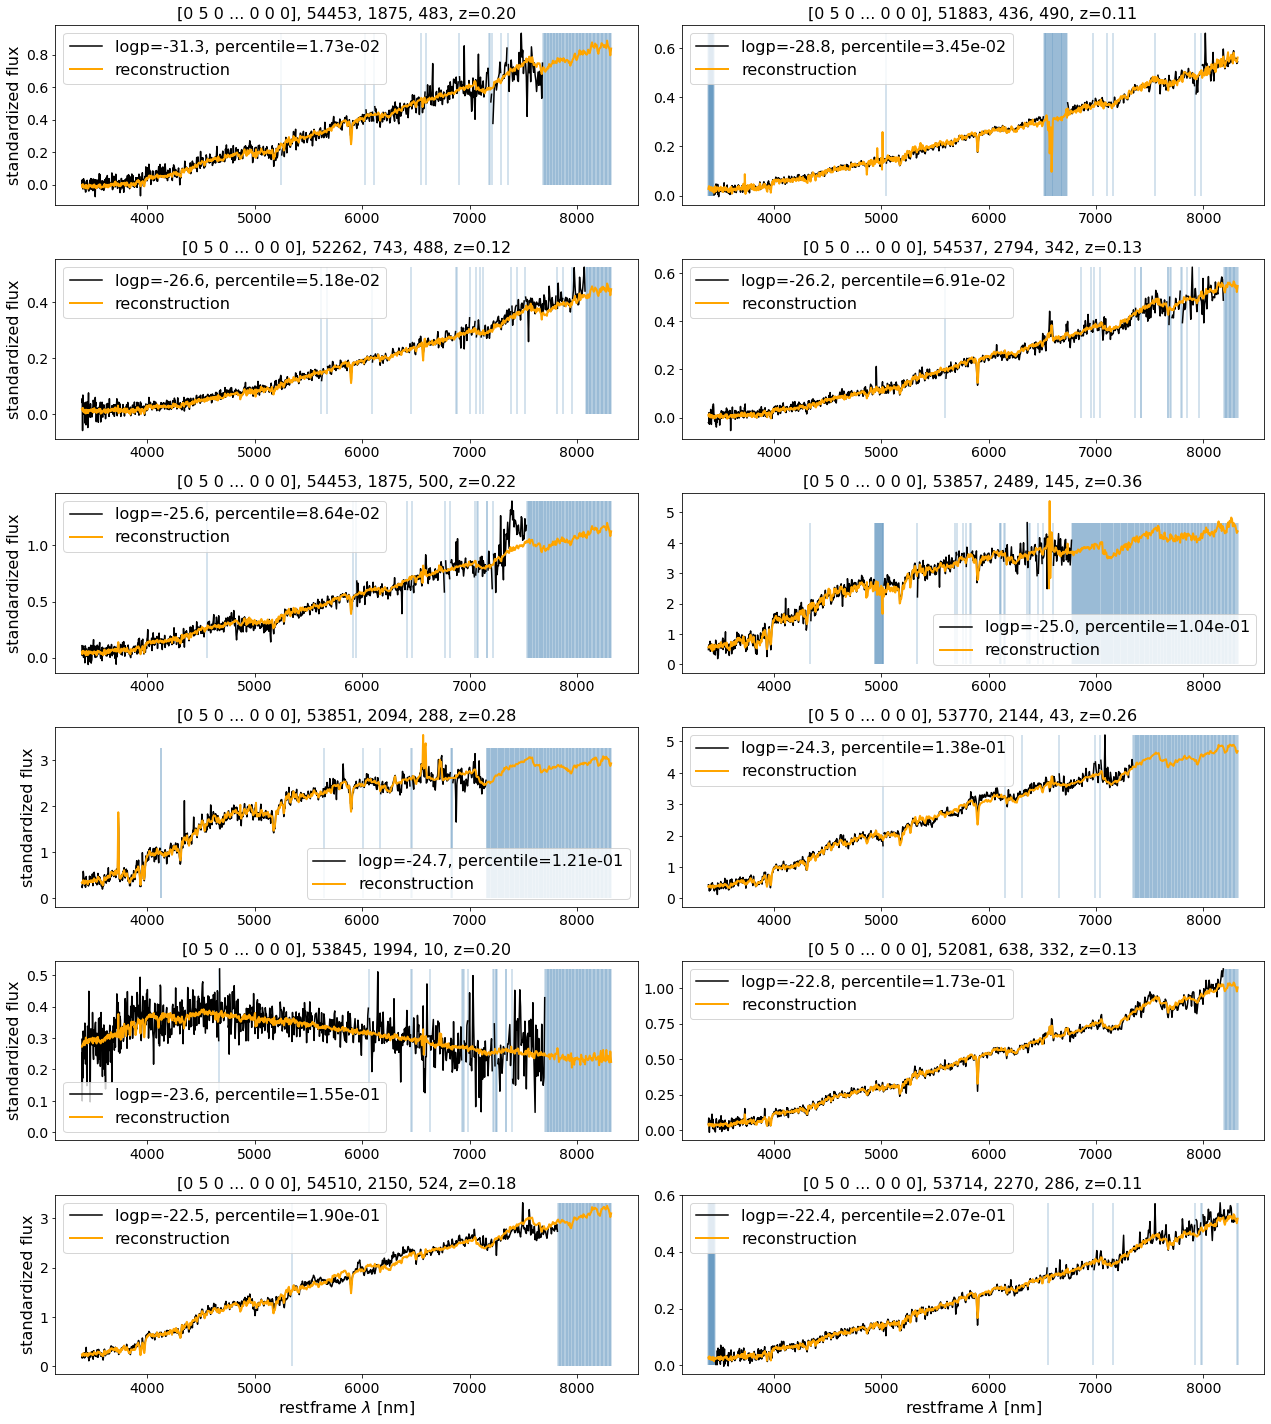

Most normal Spectra test 0


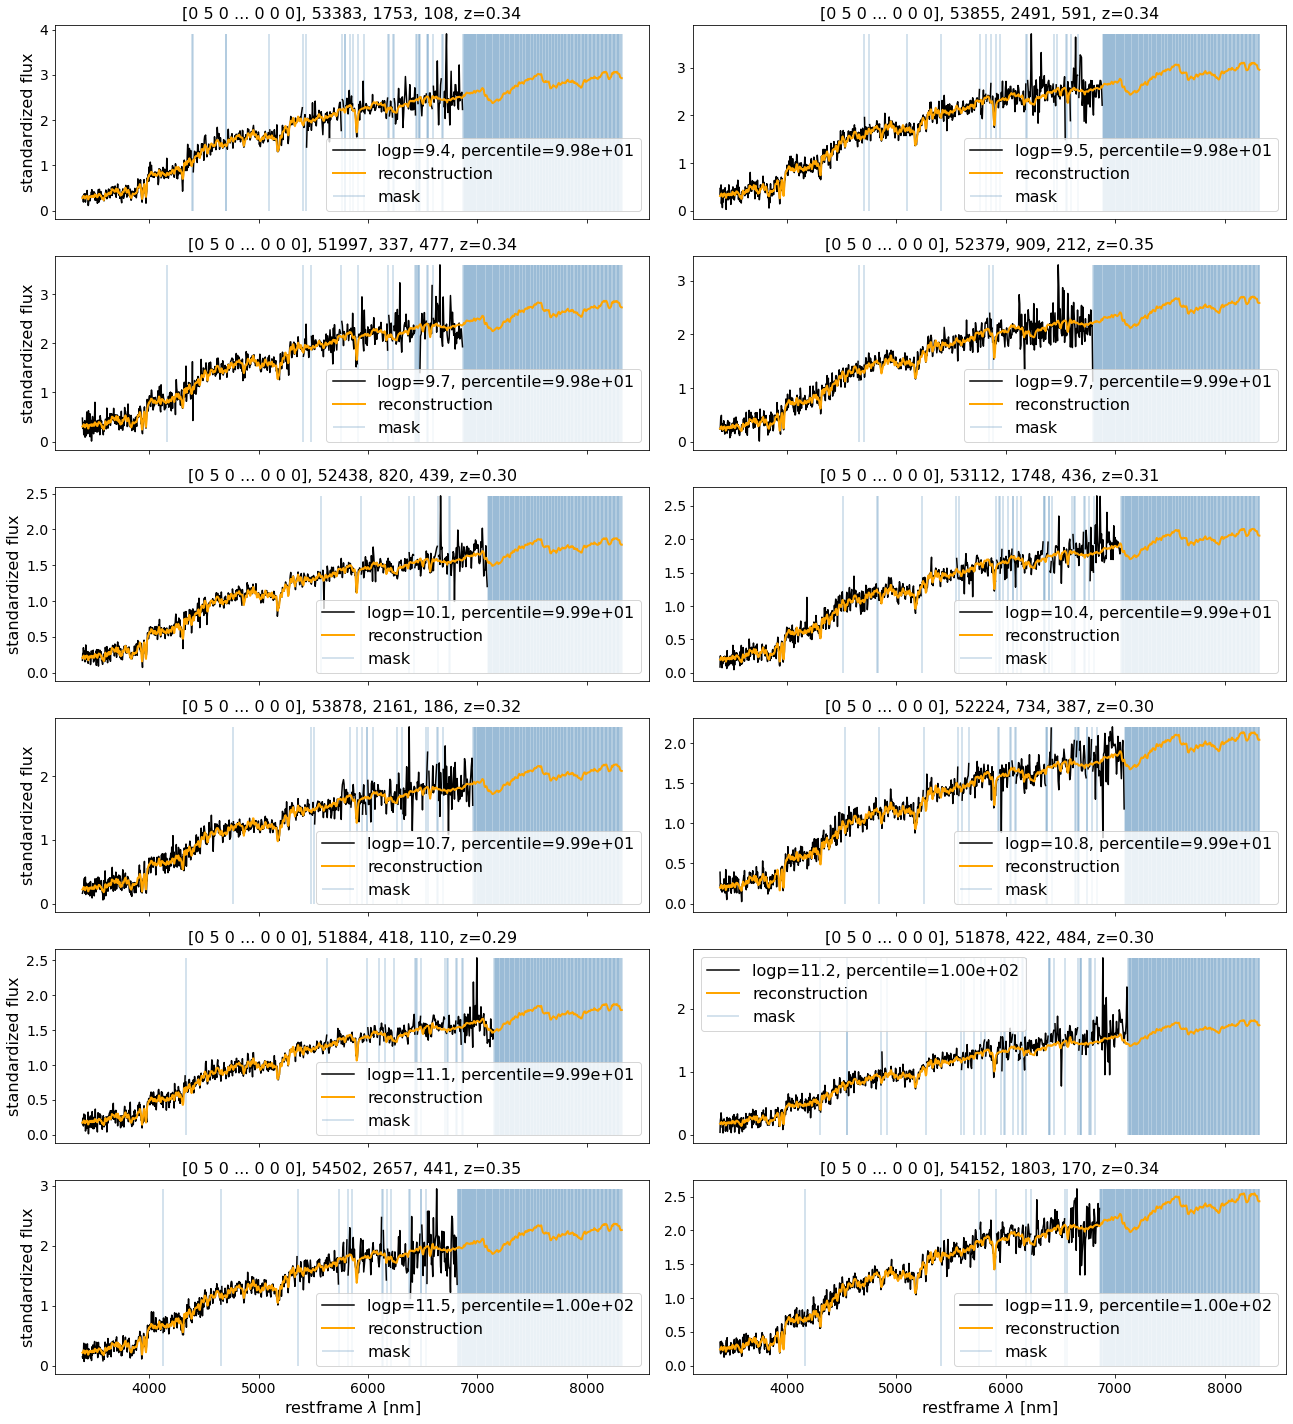

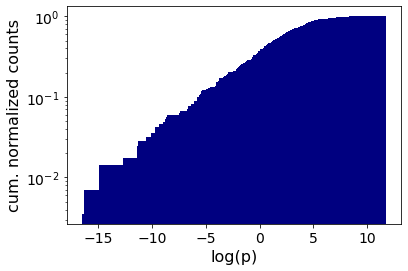

Anomalous Spectra test 1


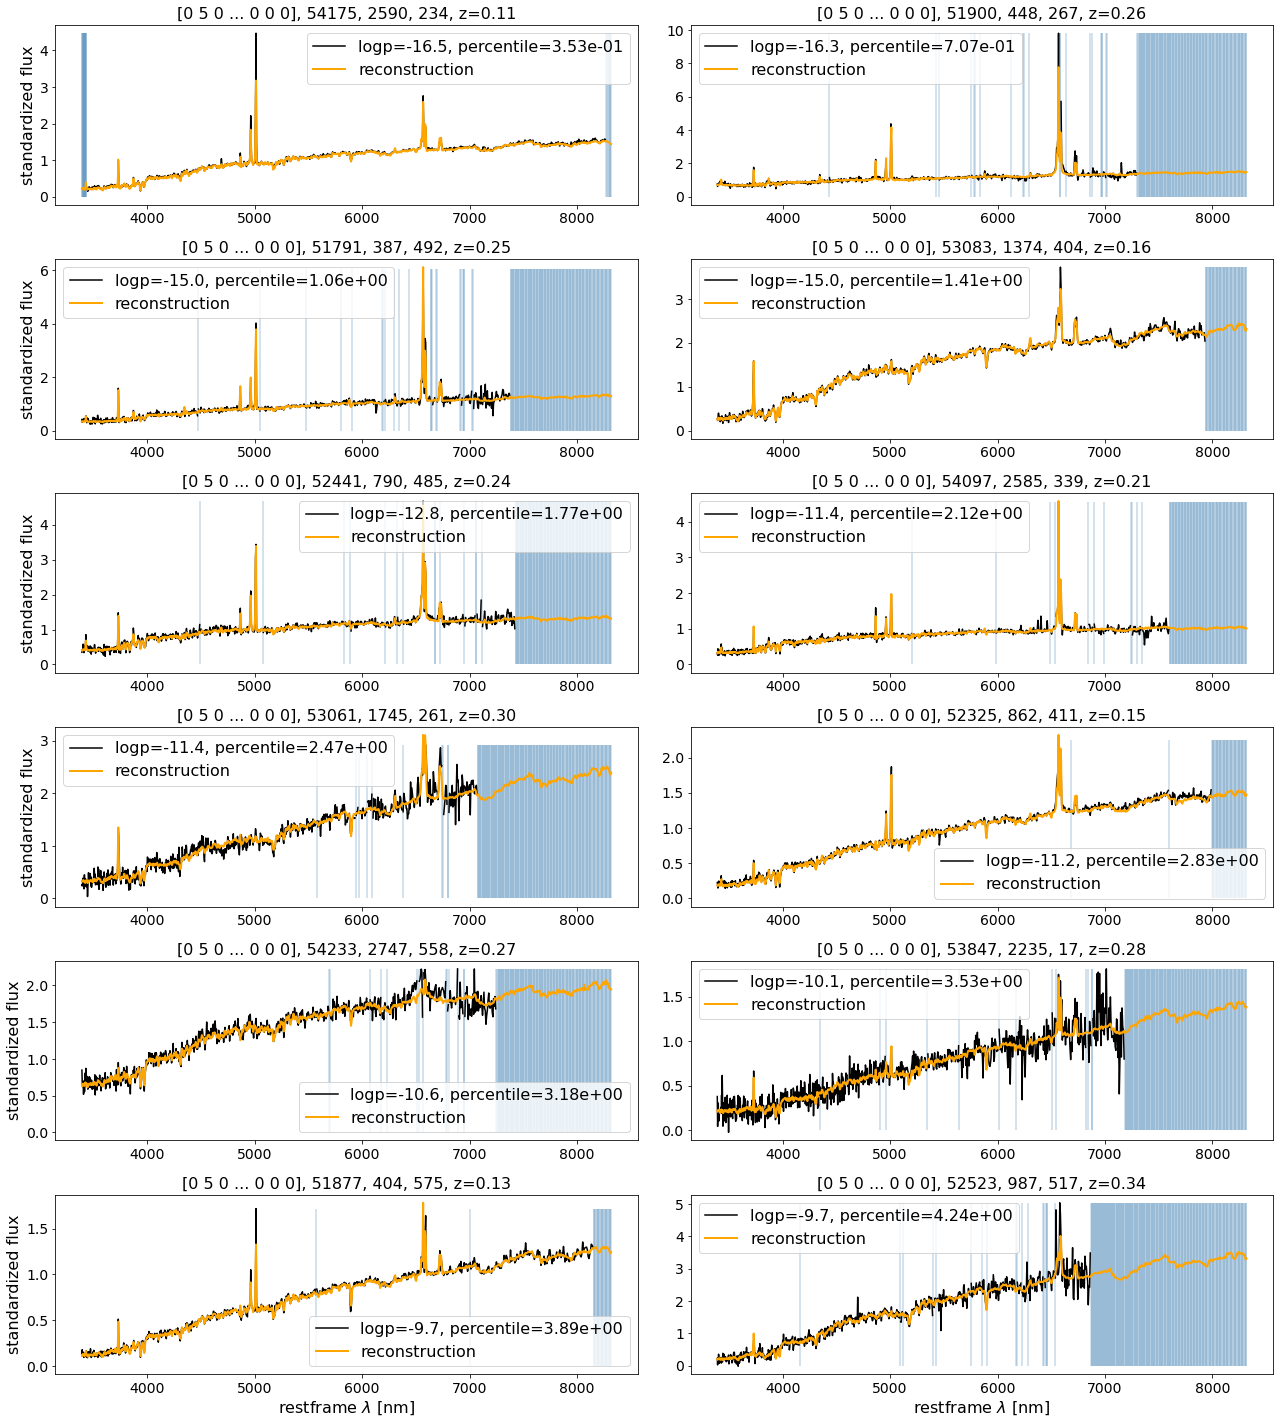

Most normal Spectra test 1


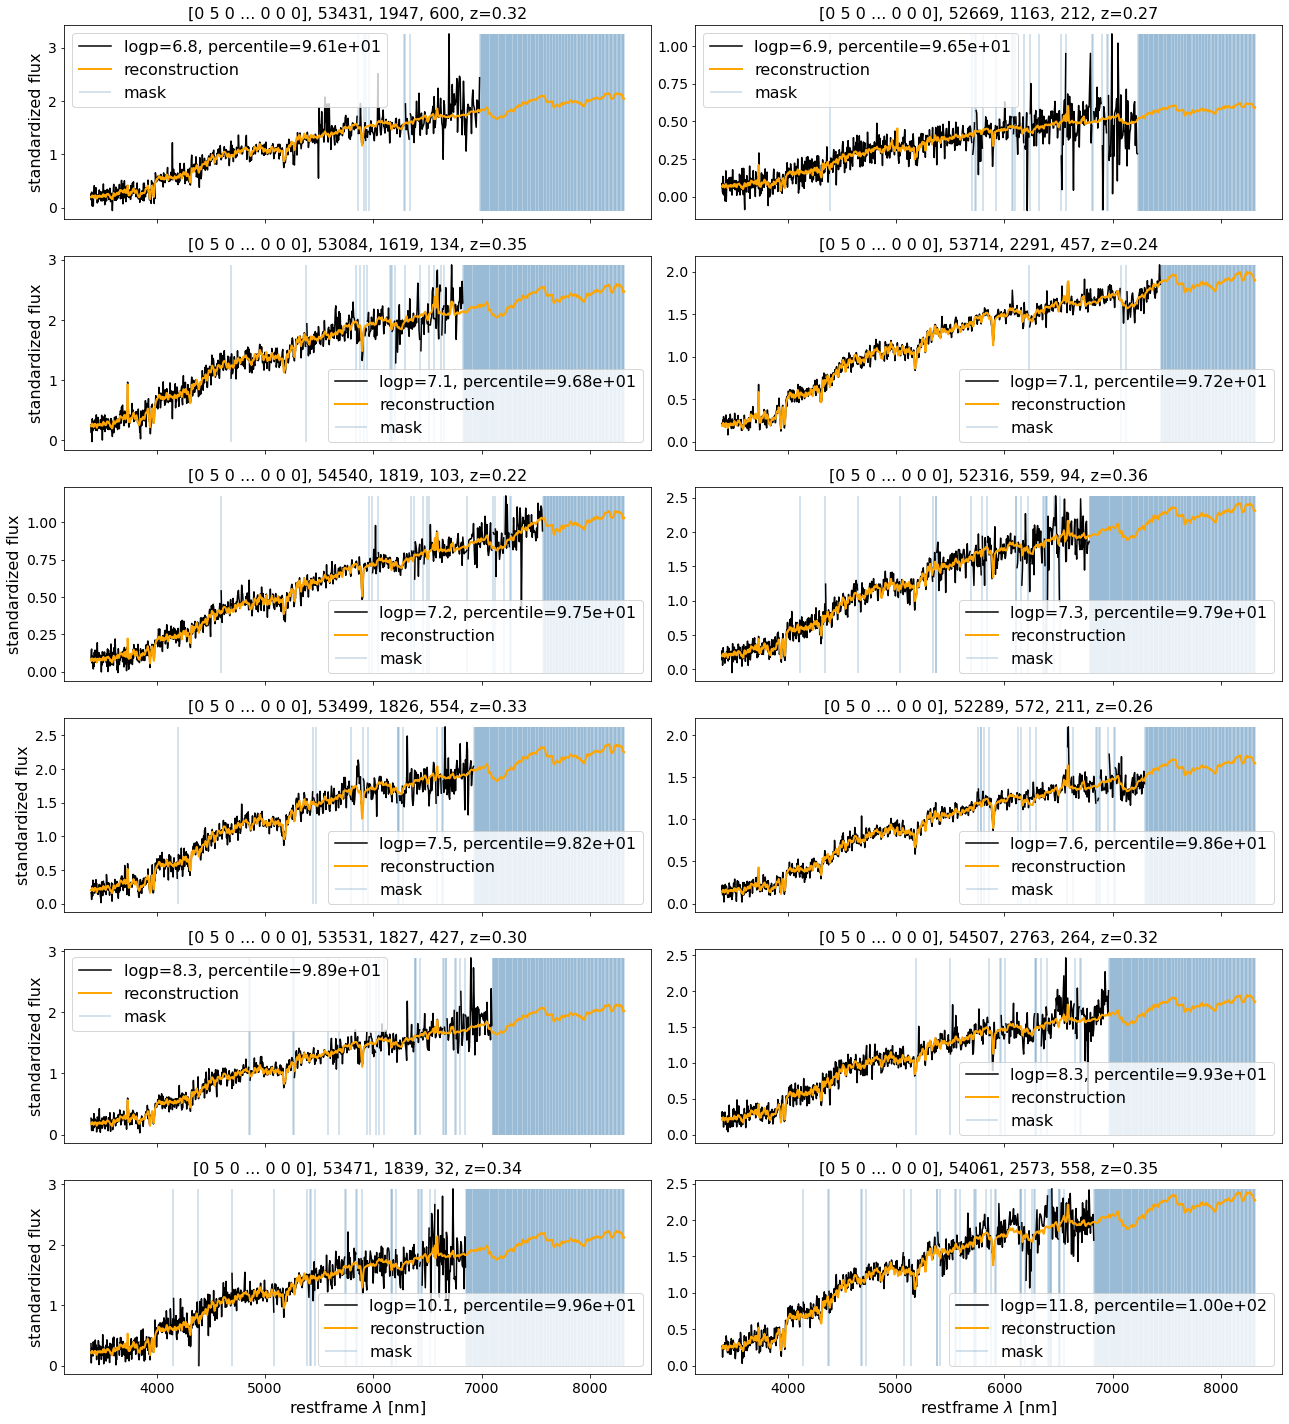

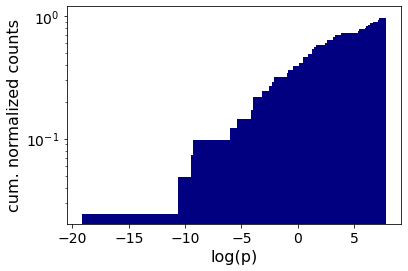

Anomalous Spectra test 2


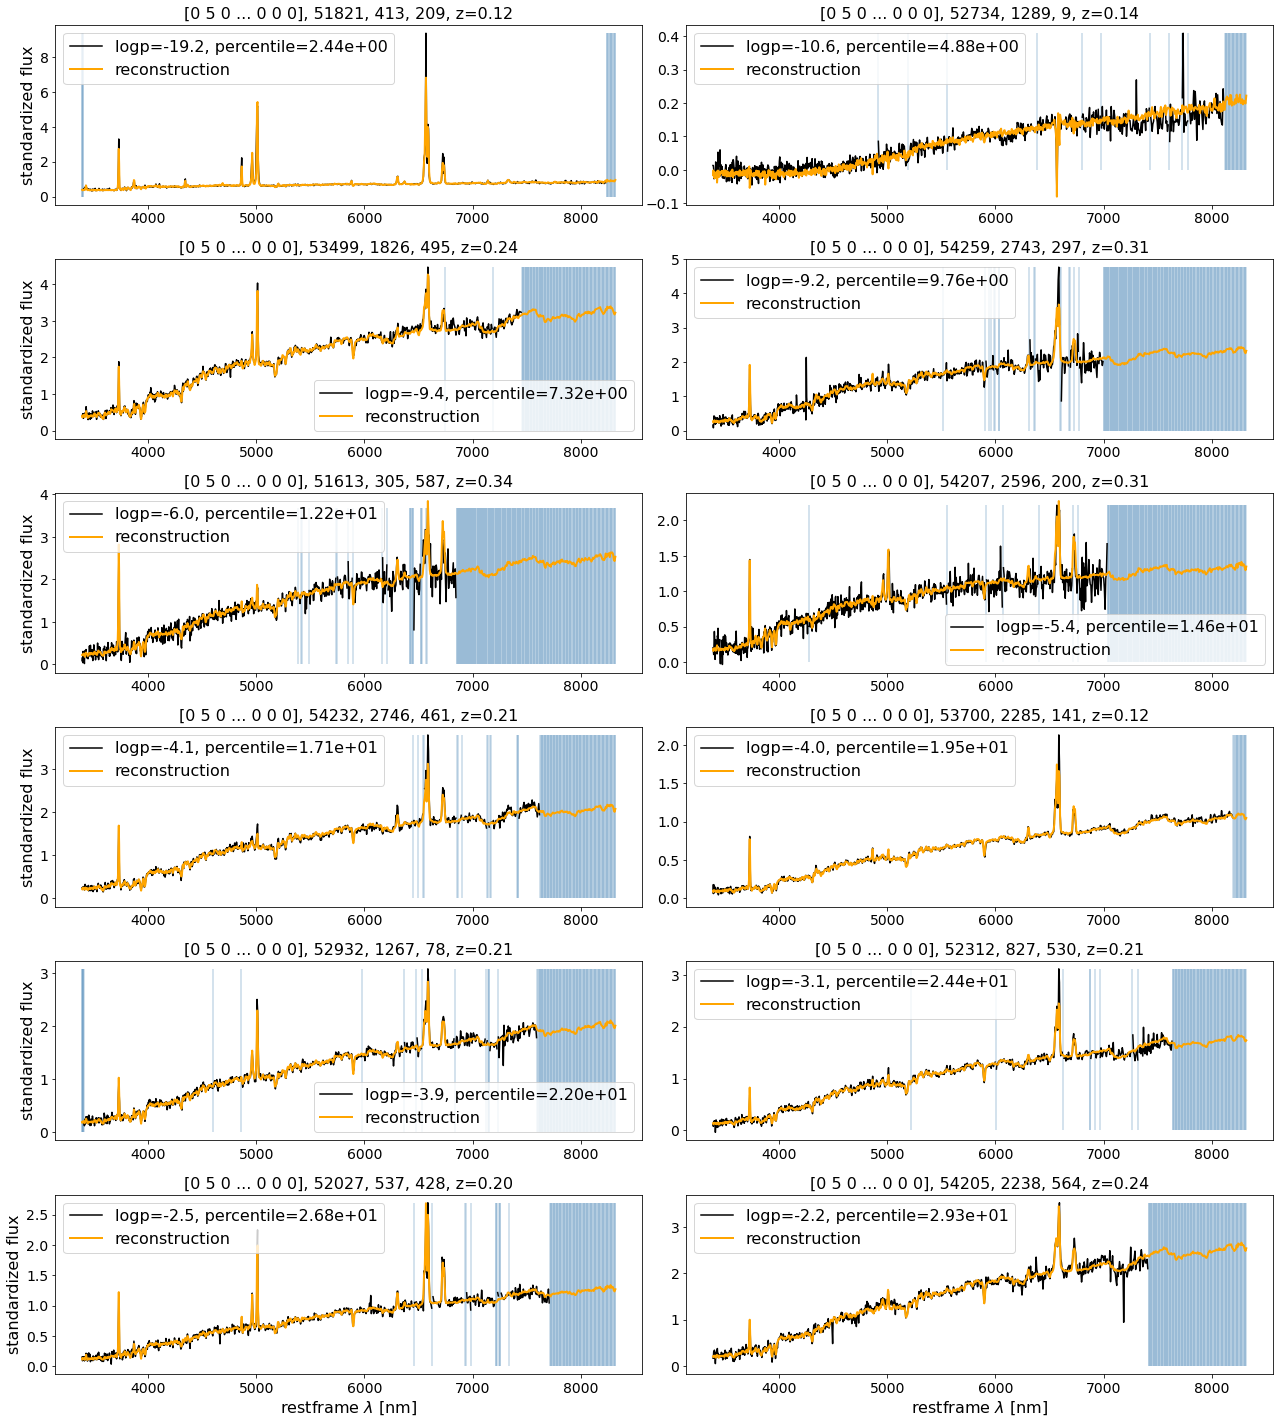

Most normal Spectra test 2


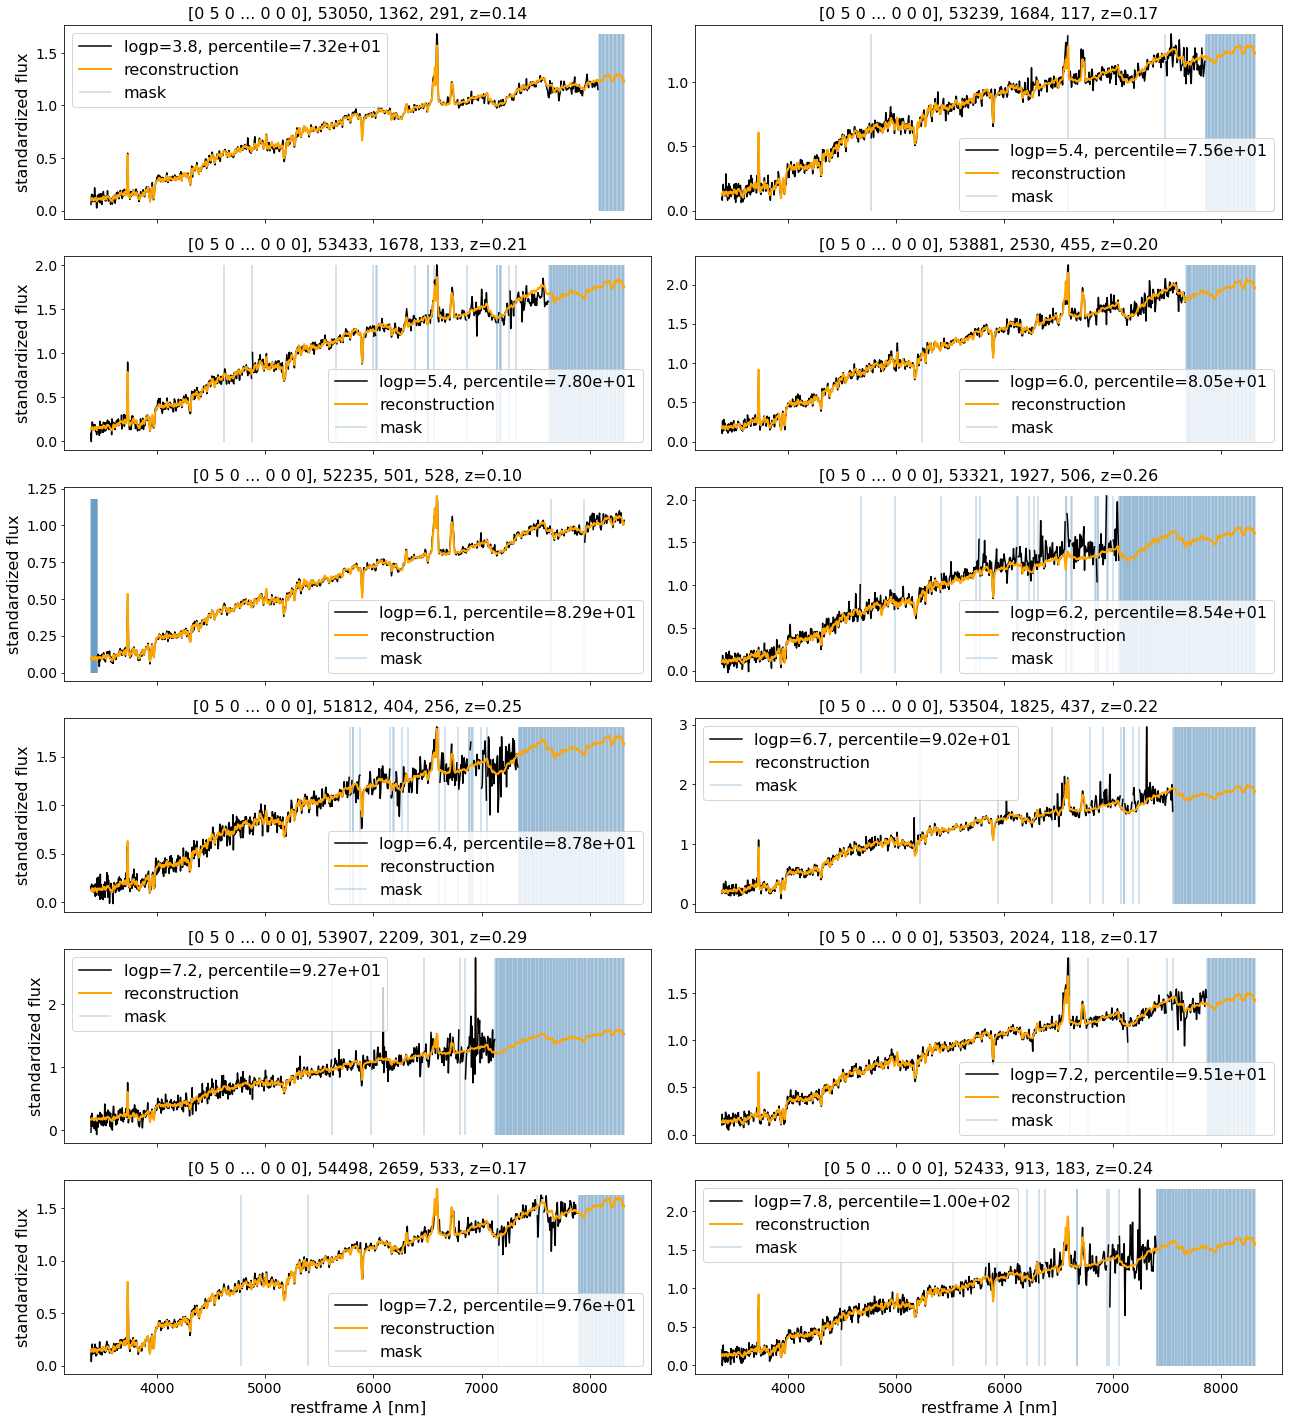

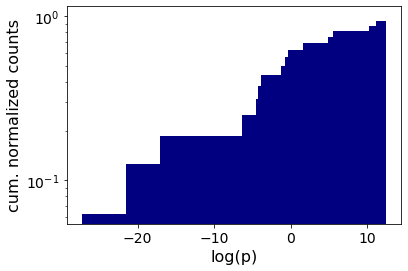

Anomalous Spectra test 3


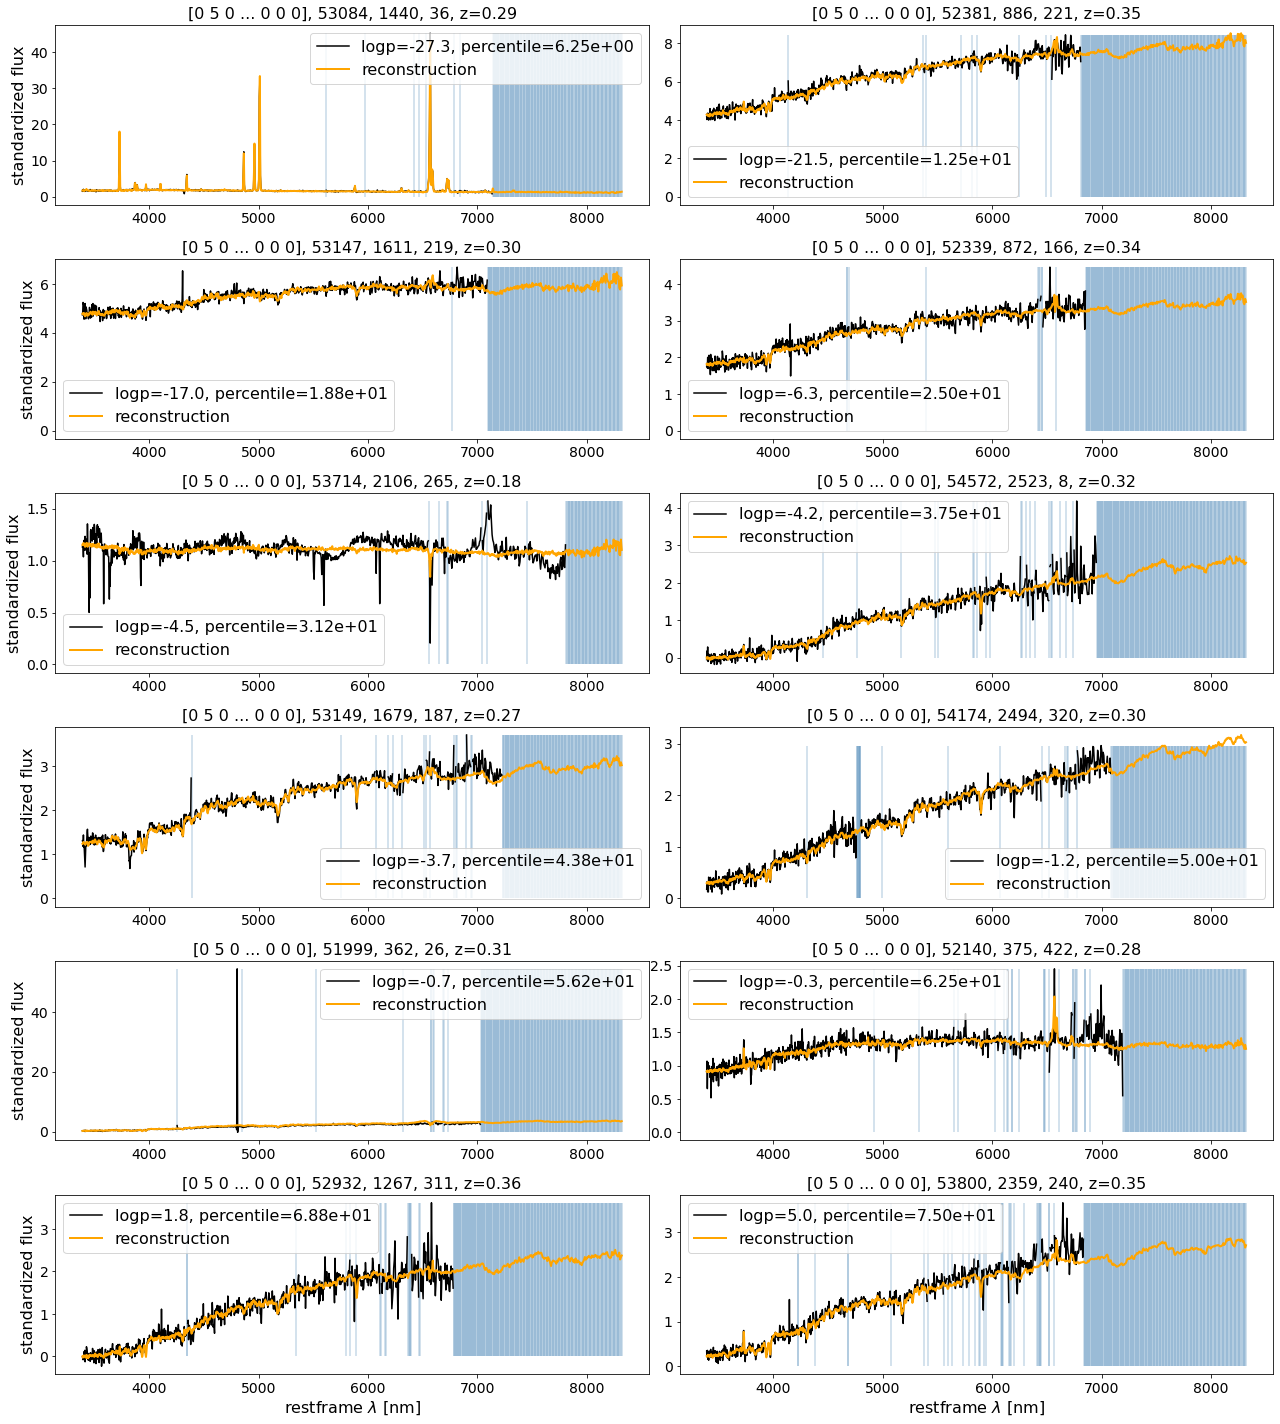

Most normal Spectra test 3


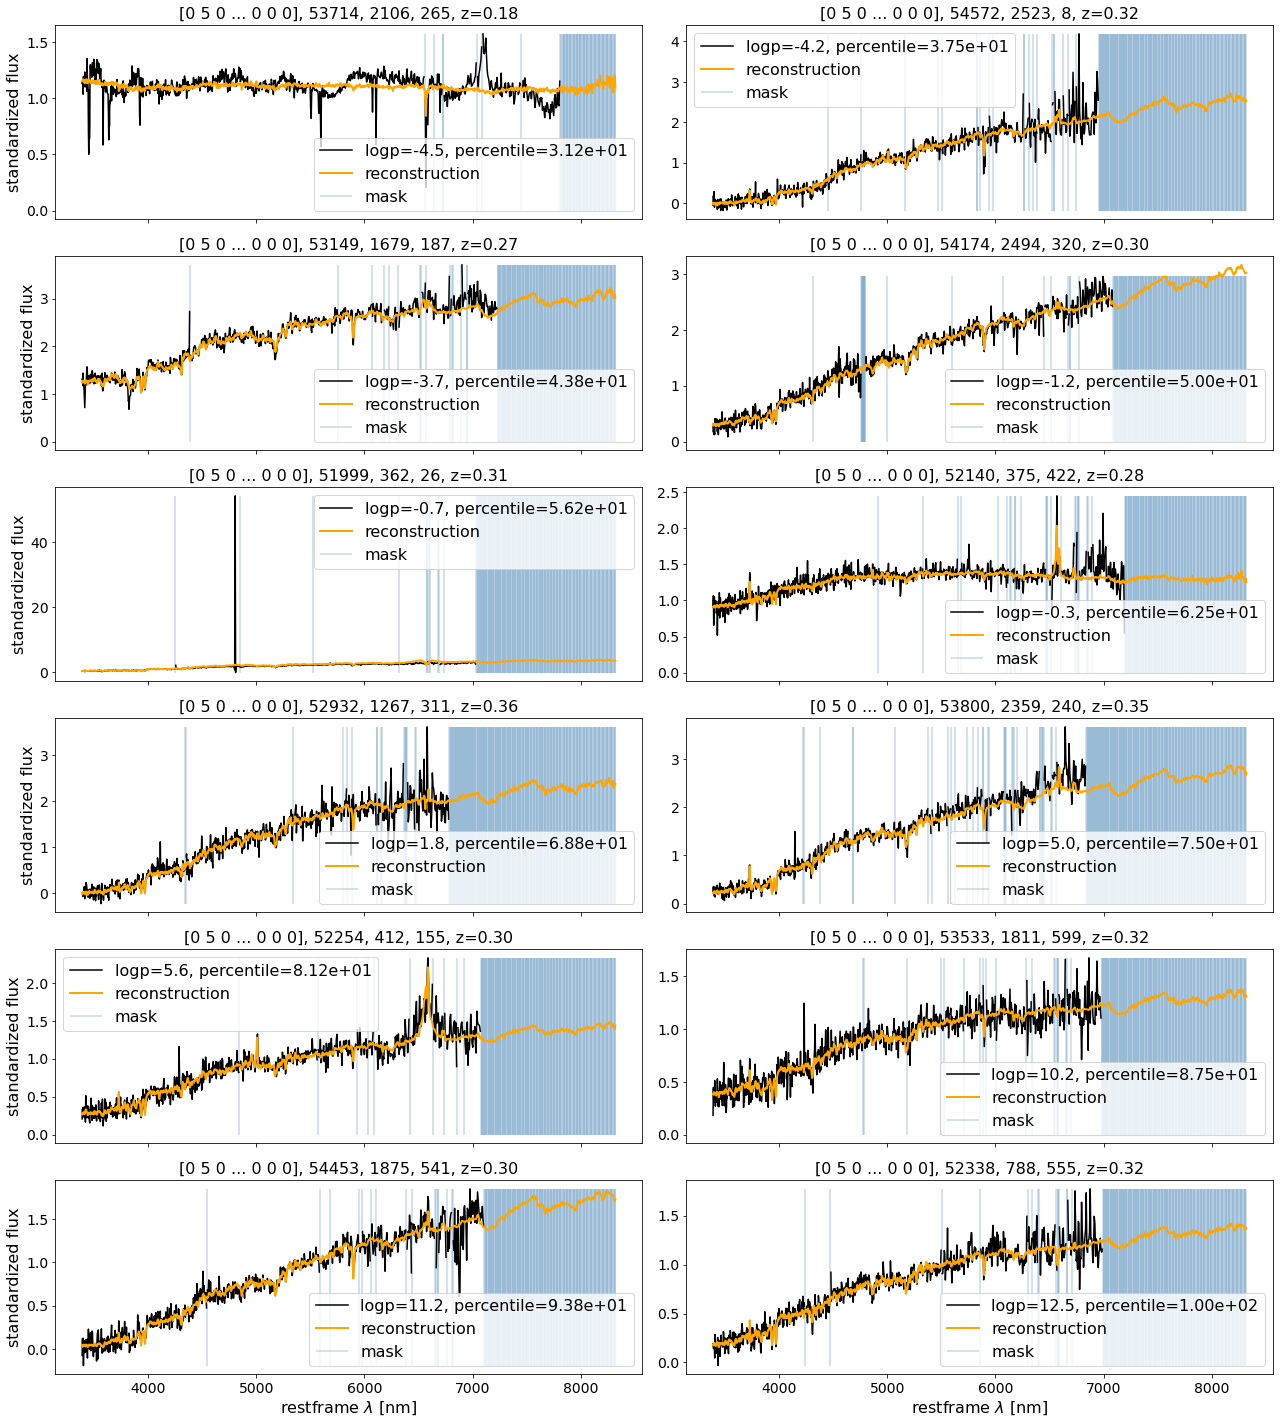

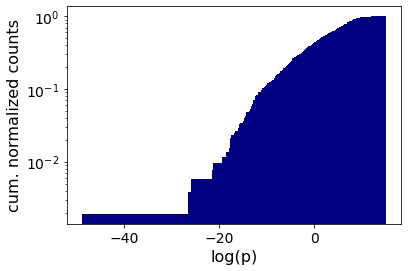

Anomalous Spectra test 4


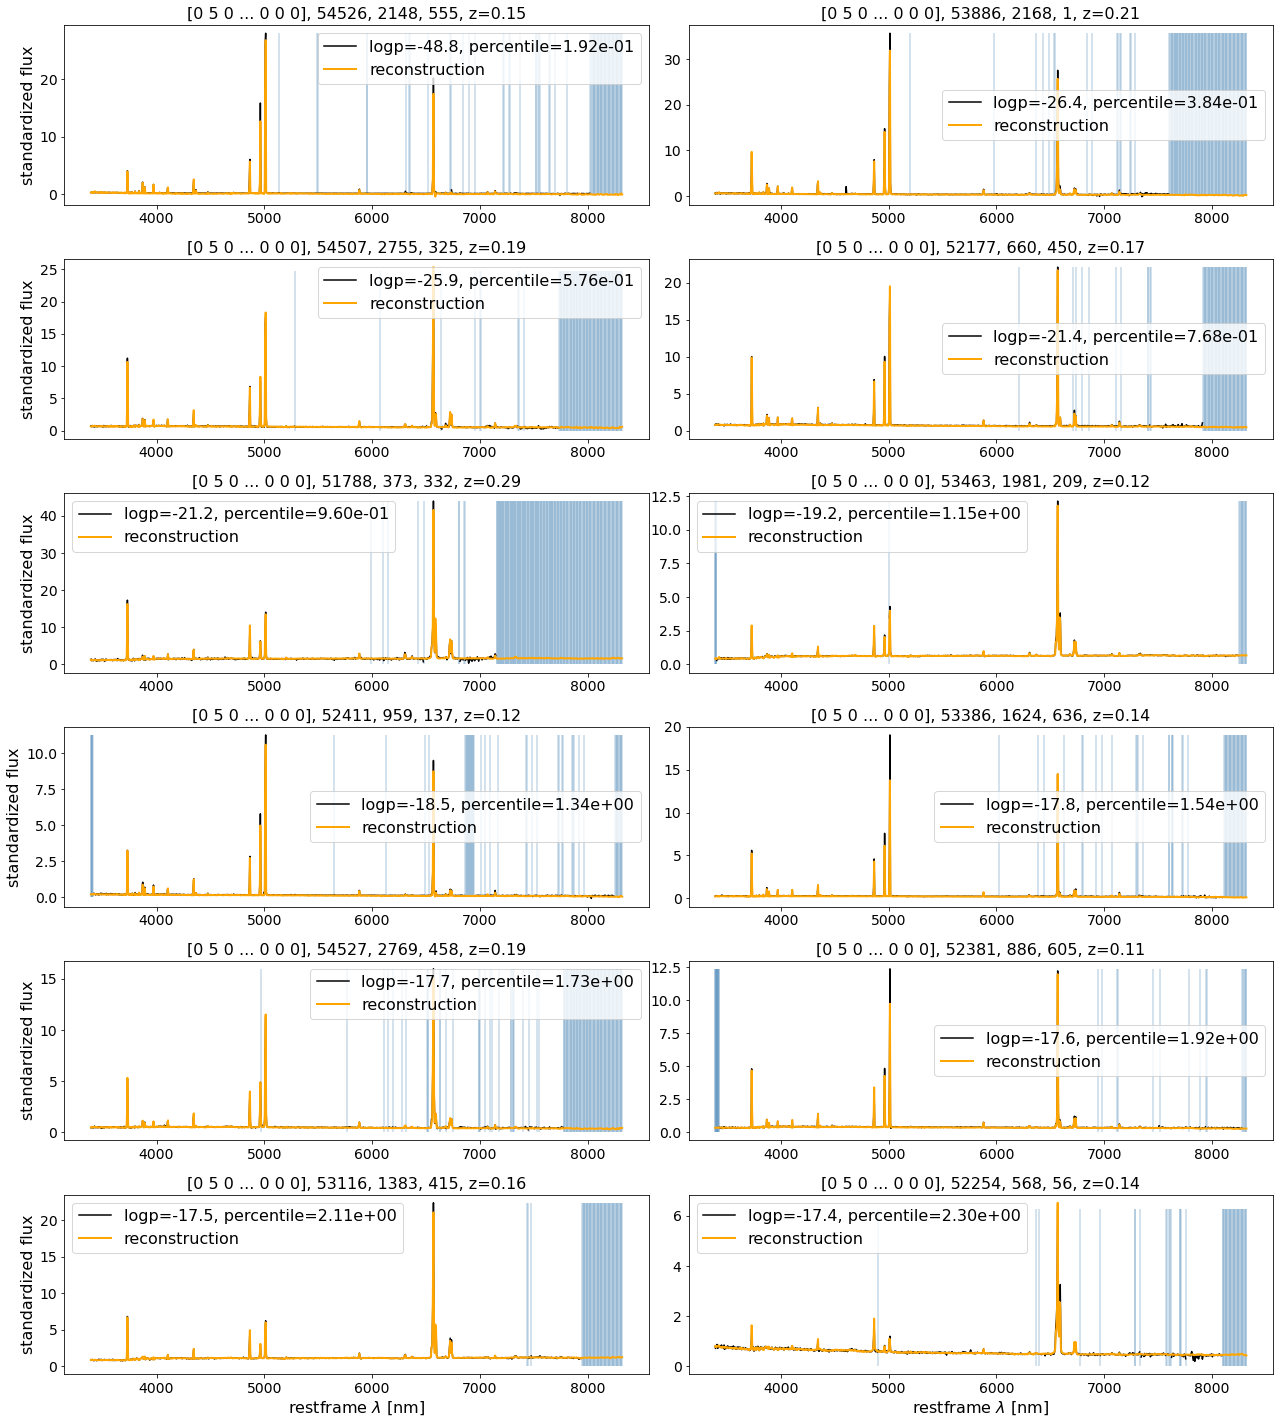

Most normal Spectra test 4


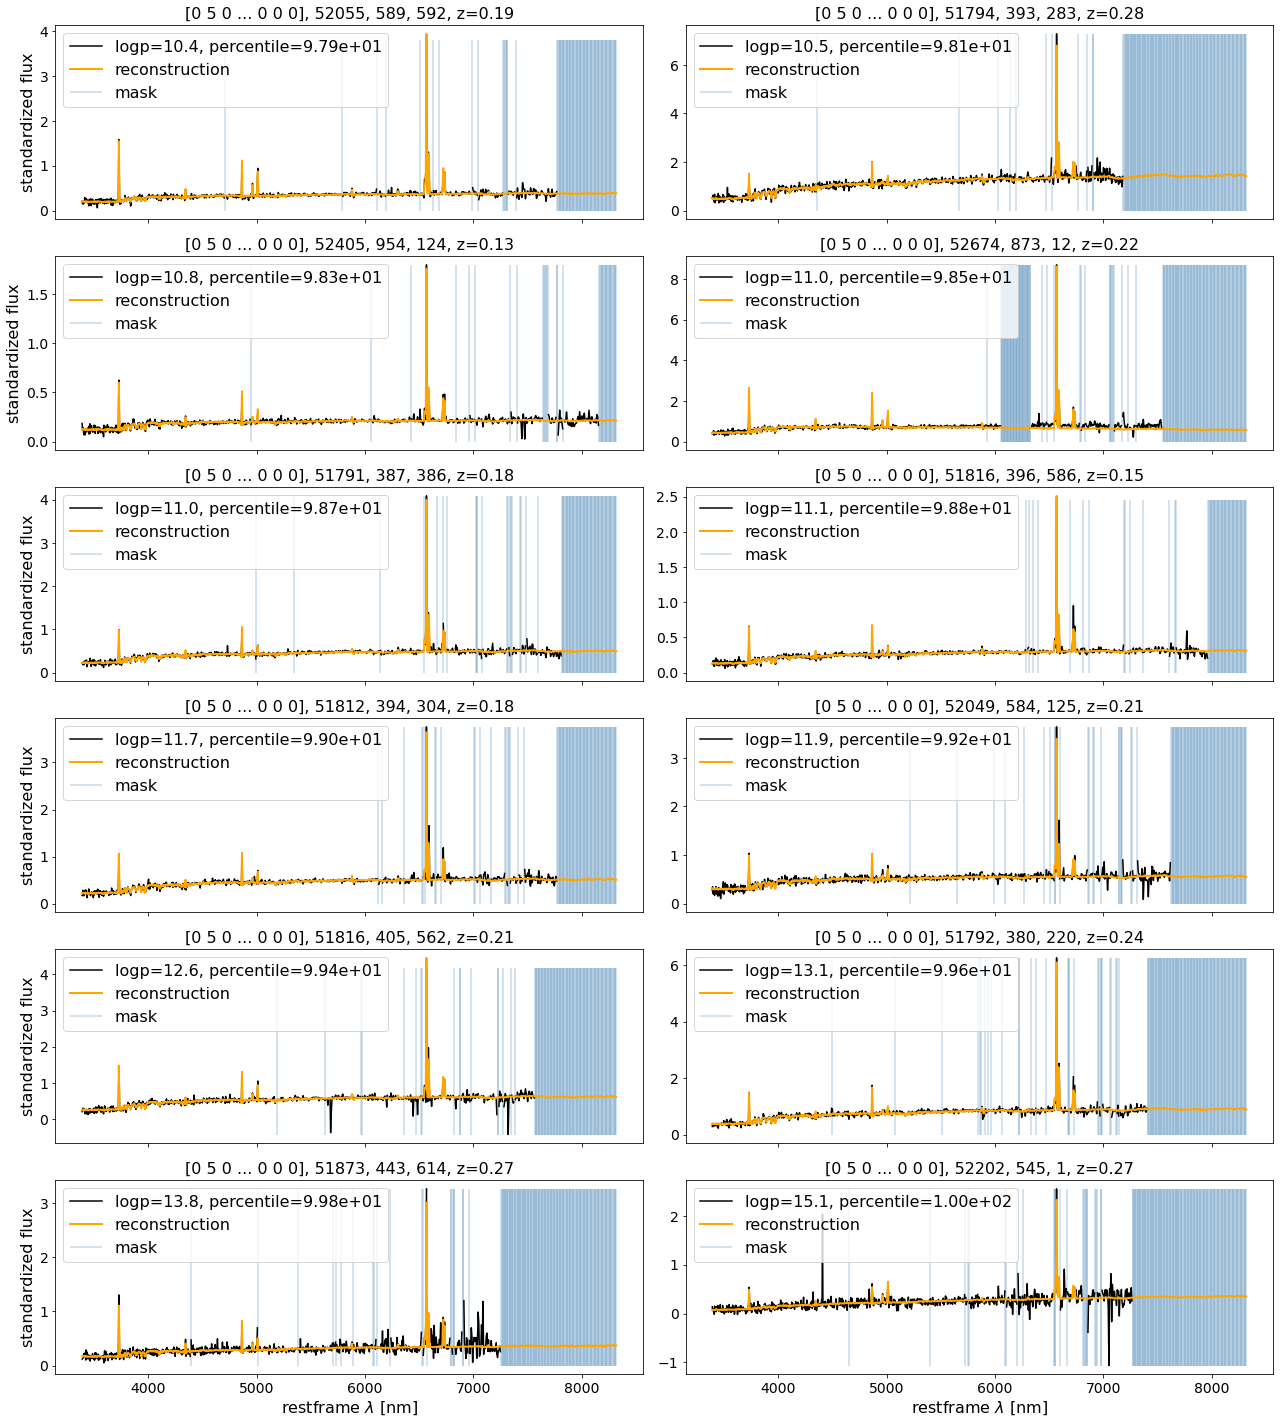

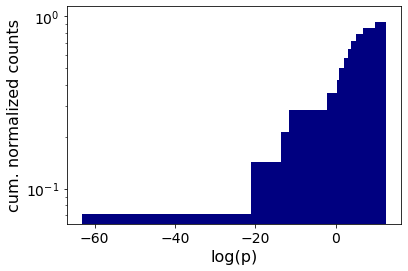

Anomalous Spectra test 5


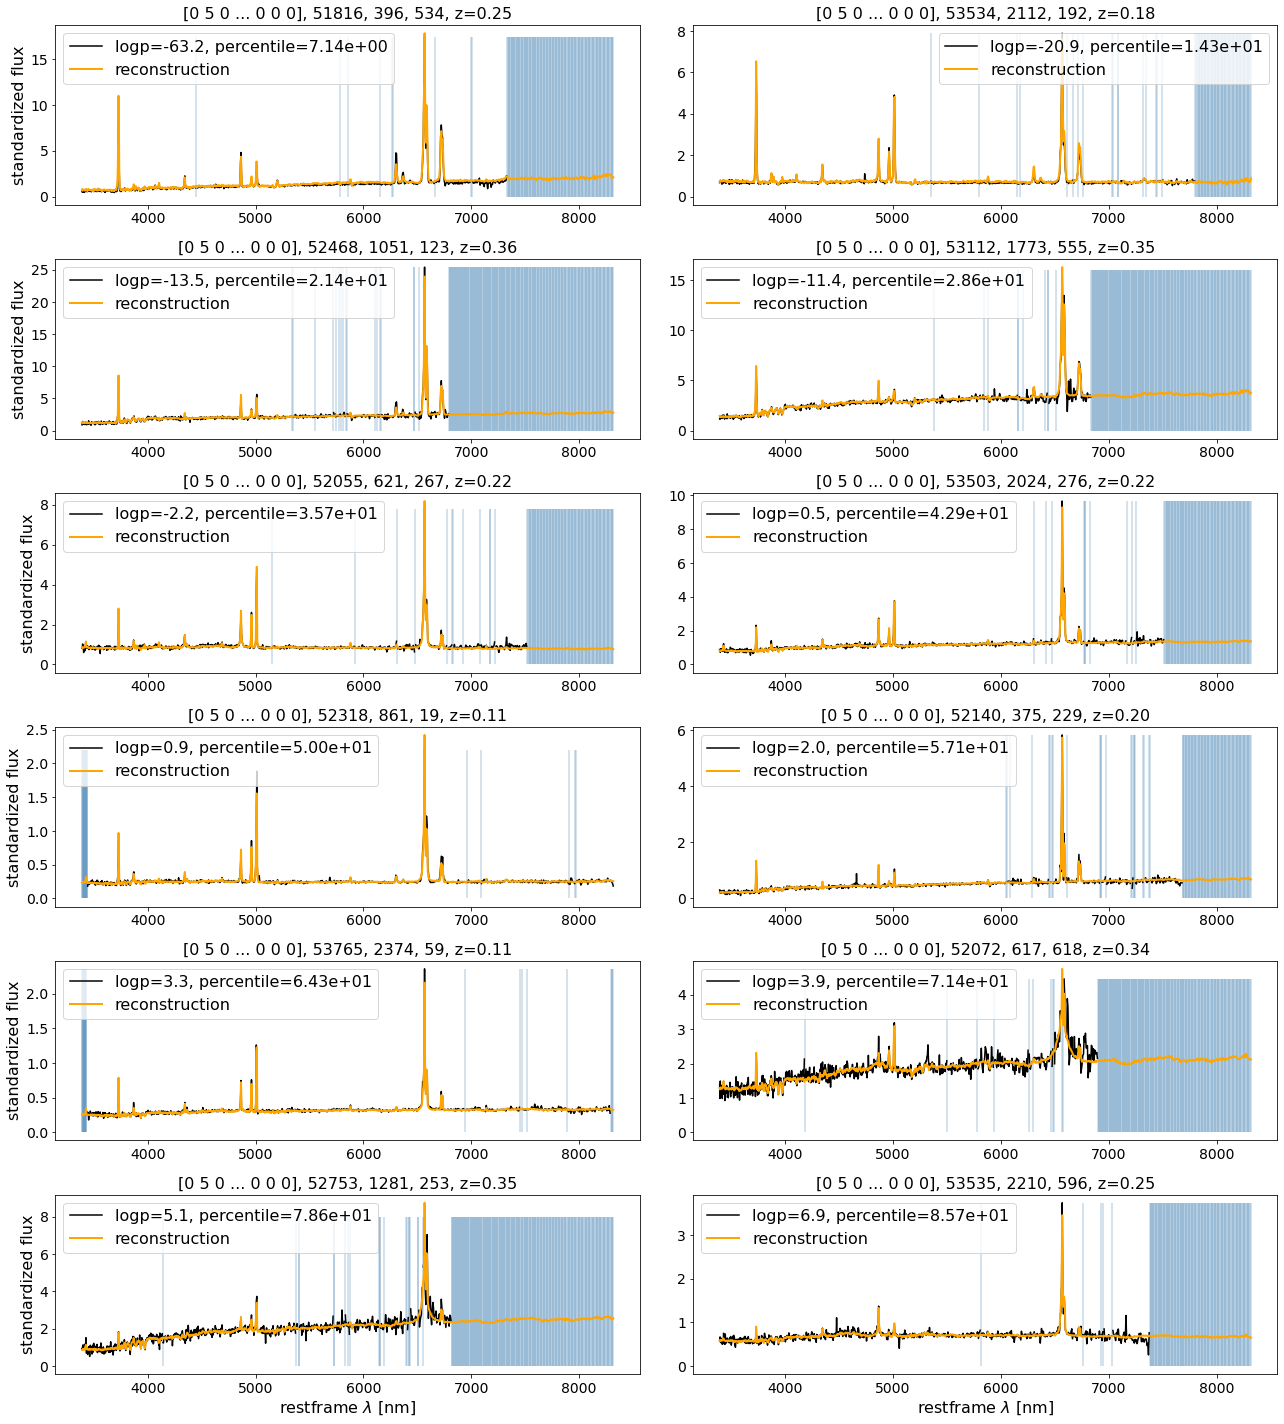

Most normal Spectra test 5


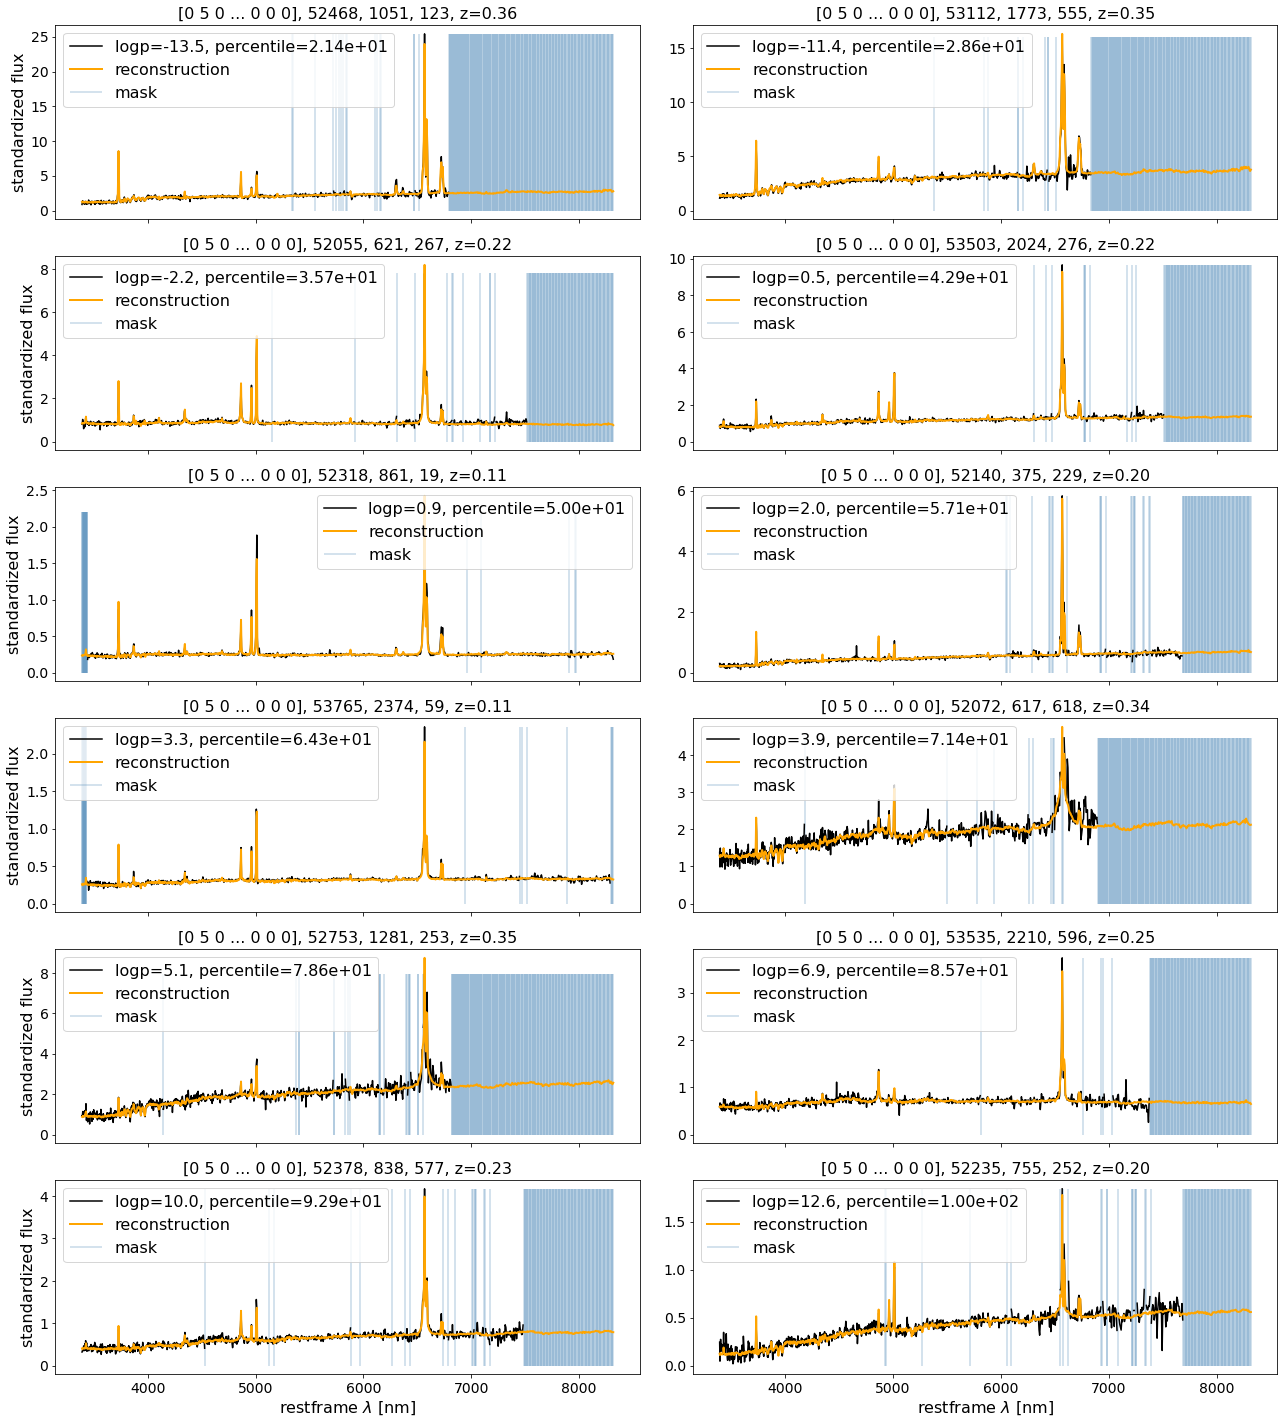

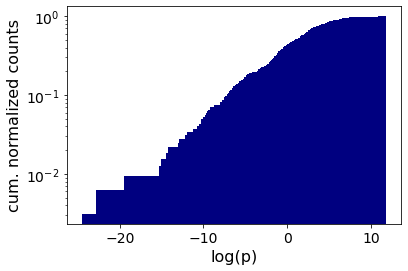

Anomalous Spectra test 6


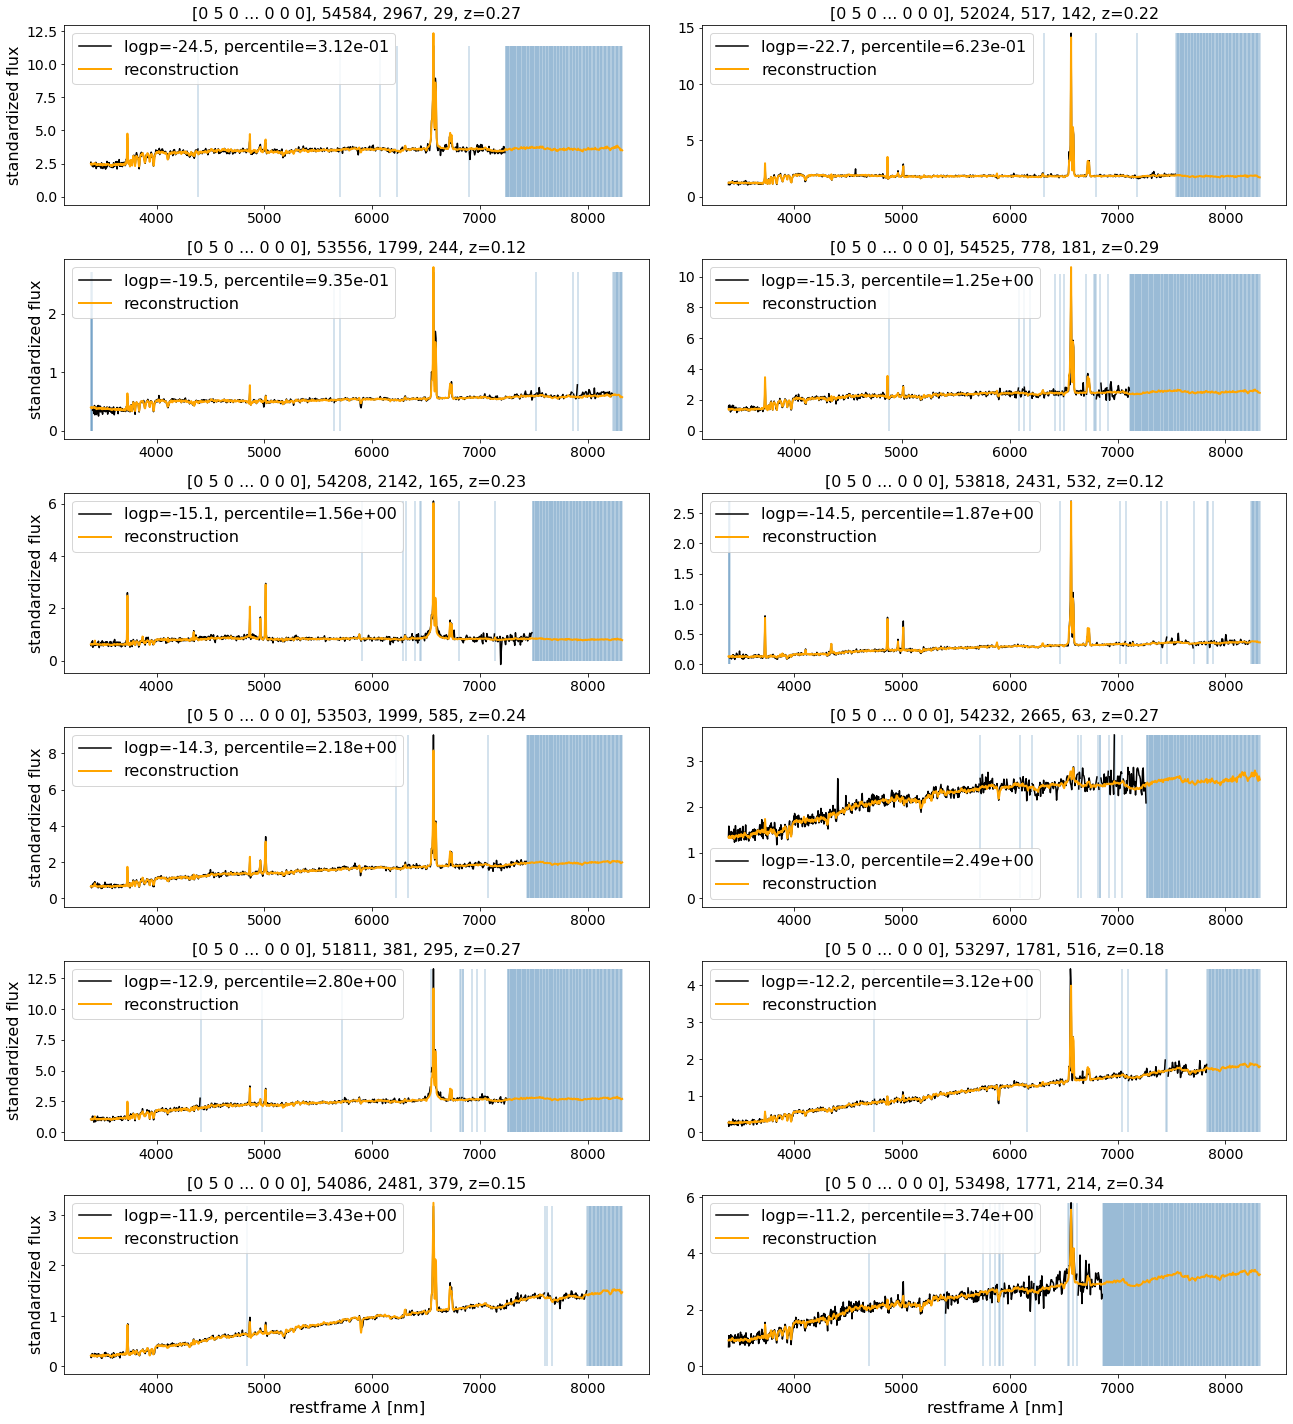

Most normal Spectra test 6


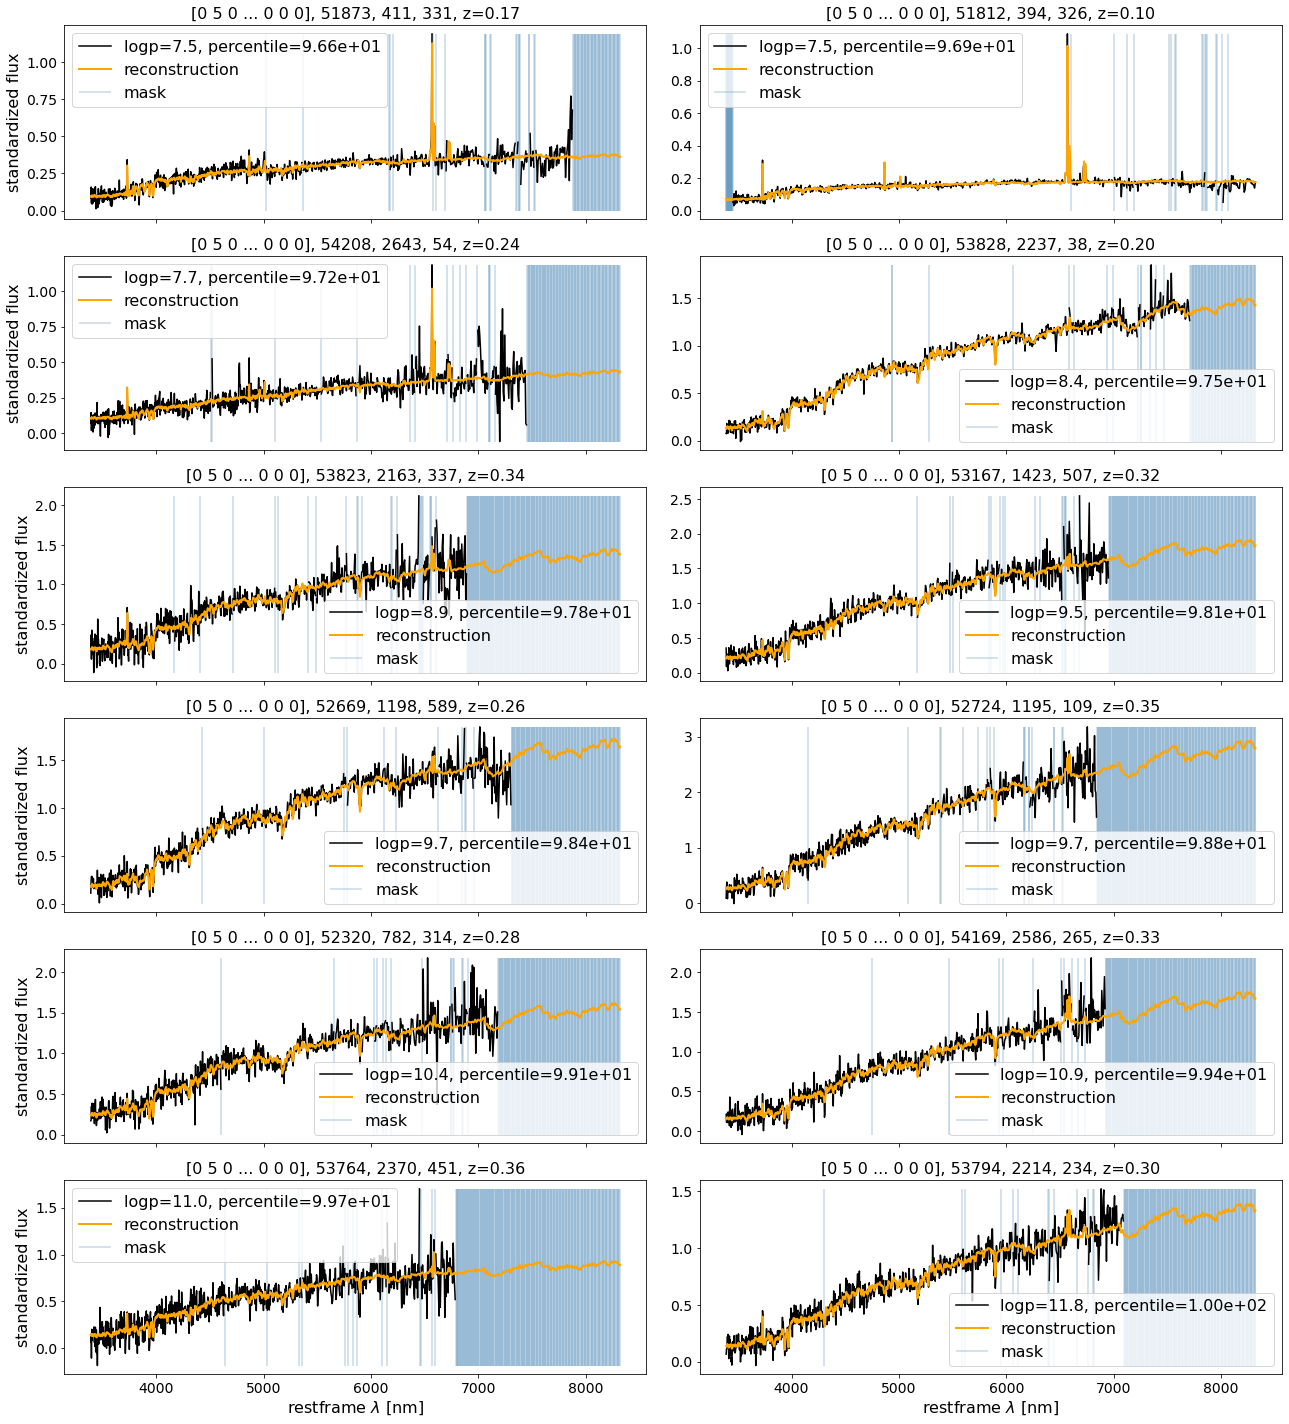

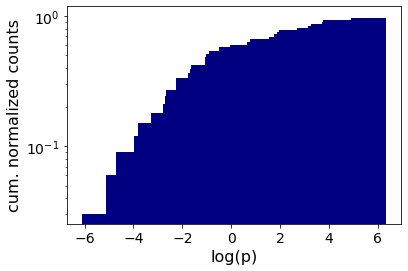

Anomalous Spectra test 7


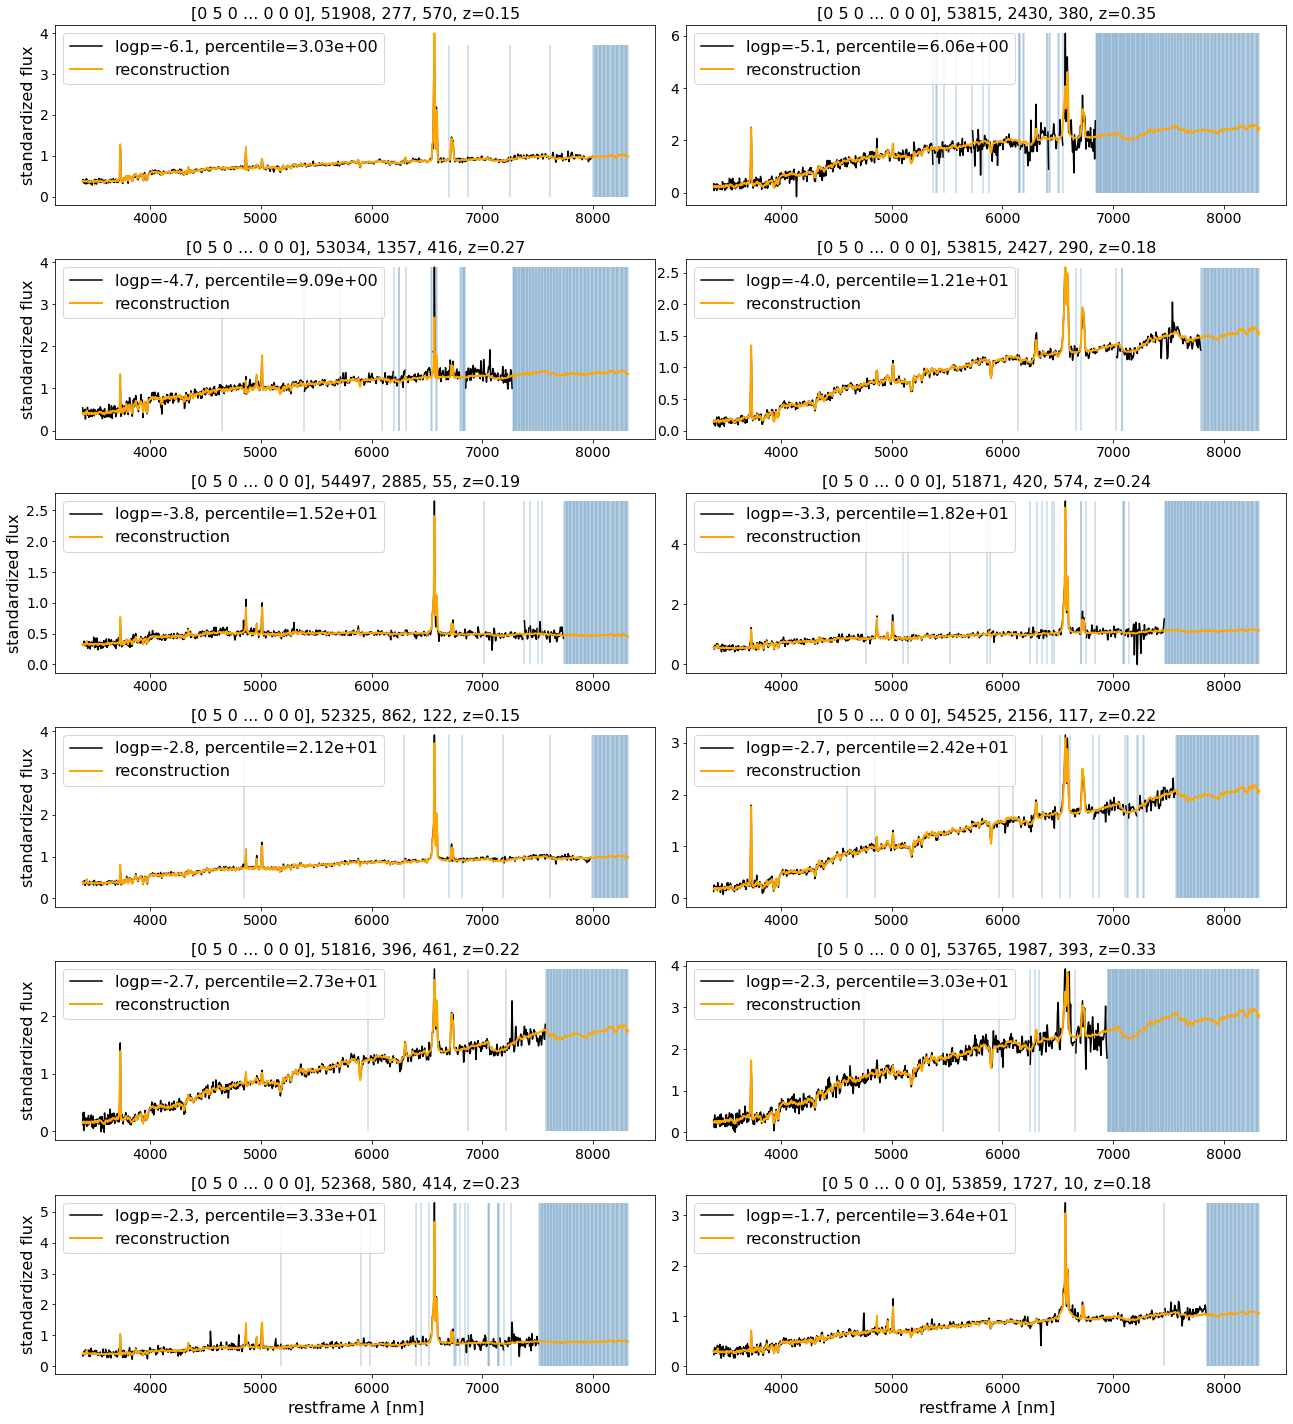

Most normal Spectra test 7


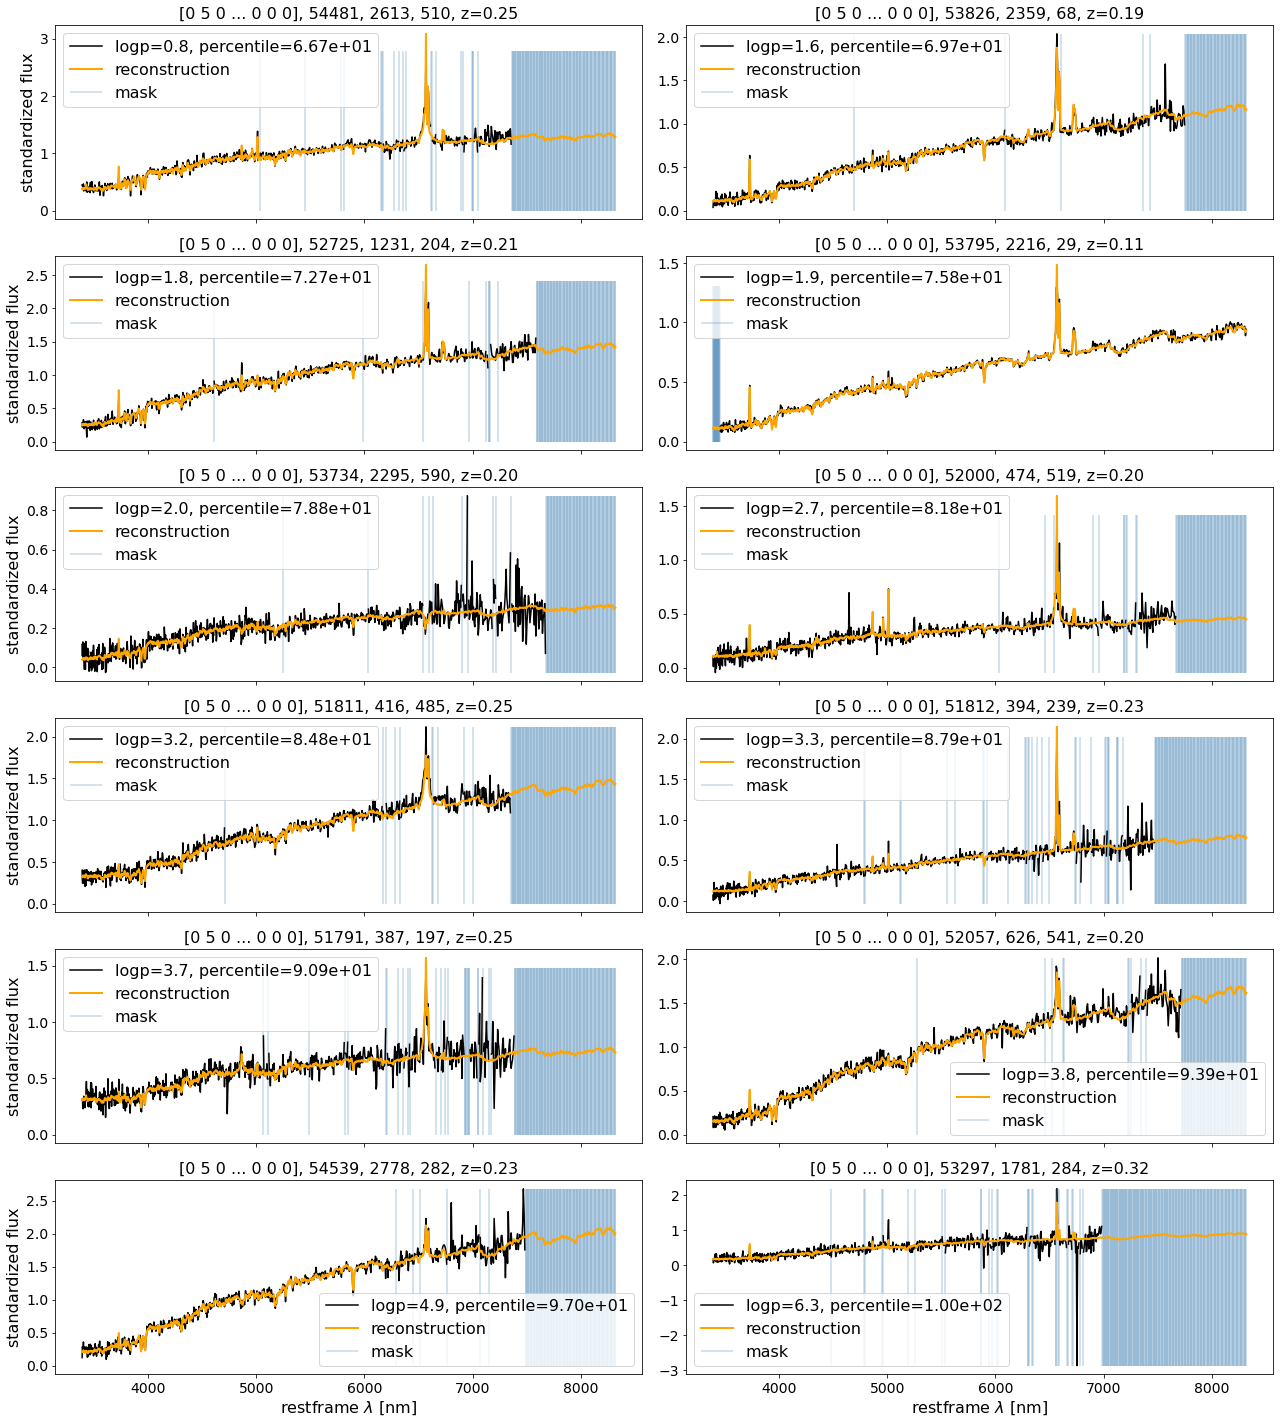

In [48]:
for mm in range(8):
    for data, name, df in zip([test],['test'],[df_test]):
        ind = np.where(data['subclass']==mm)[0]

        dens            = df['logp'].iloc[ind].to_numpy()

        ind_ood         = np.argsort(dens)
        dens_sorted     = dens[ind_ood]

        cum, bins, _      = plt.hist(dens_sorted,bins=500,density=True, cumulative=True, log=True, color='navy')
        plt.xlabel('log(p)')
        plt.ylabel('cum. normalized counts')
        plt.savefig(os.path.join(plotpath,'relabeled/logp/','logp_hist_%s_%s.pdf'%(name,(le.inverse_transform([mm])[0]).decode('utf8'))), bbox_inches='tight')
        plt.show()
        plt.close()

        outliers_decoded  = decoded[name][ind][ind_ood]
        outliers_input    = masked[name][ind][ind_ood]

        wlmin, wlmax      = (3388,8318)
        fixed_num_bins    = 1000
        wl_range          = (np.log10(wlmin),np.log10(wlmax))
        new_wl            = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

        print('Anomalous Spectra', name, mm)
        fi, ax = plt.subplots(6,2,figsize=(18,20))
        ax = ax.flatten()
        for ii in range(min(len(dens_sorted),12)):
            percentile = scipy.stats.percentileofscore(dens_sorted, dens_sorted[ii], kind='rank')
            ax[ii].set_title('%s, %d, %d, %d, z=%.2f'%(classes[data['class'][ind][ind_ood][ii]], data['MJD'][ind][ind_ood][ii],data['plate'][ind][ind_ood][ii],data['fiber'][ind][ind_ood][ii],data['z'][ind][ind_ood][ii]))
            ax[ii].plot(new_wl[1:],outliers_input[ii],label='logp=%.1f, percentile=%.2e'%(dens_sorted[ii],percentile), color='black')
            ax[ii].vlines( x=new_wl[1:][np.squeeze(~data['mask'][ind][ind_ood][ii].astype(bool))], ymin=0,ymax=max(data['spec'][ind][ind_ood][ii]), color='steelblue',alpha=0.3)
            ax[ii].plot(new_wl[1:],outliers_decoded[ii], label='reconstruction',ls='-', color='orange', lw=2)

            ax[ii].legend()
            if ii in [10,11]:
                ax[ii].set_xlabel(r'restframe $\lambda$ [nm]')
            if ii%2==0:
                ax[ii].set_ylabel(r'standardized flux')        
        plt.tight_layout()
        plt.savefig(os.path.join(plotpath,'relabeled/logp/','logp_outliers_class_%s_%s.pdf'%(name,(le.inverse_transform([mm])[0]).decode('utf8'))), bbox_inches='tight')
        plt.show()
        plt.close()

        print('Most normal Spectra', name, mm)
        fi, ax = plt.subplots(6,2,figsize=(18,20),sharex=True)
        ax = ax.flatten()
        for nn, ii in enumerate(range(len(ind_ood)-min(12,len(dens_sorted)),len(ind_ood))):
            percentile = scipy.stats.percentileofscore(dens_sorted, dens_sorted[ii], kind='rank')
            ax[nn].set_title('%s, %d, %d, %d, z=%.2f'%(classes[data['class'][ind][ind_ood][ii]], data['MJD'][ind][ind_ood][ii],data['plate'][ind][ind_ood][ii],data['fiber'][ind][ind_ood][ii],data['z'][ind][ind_ood][ii]))
            ax[nn].plot(new_wl[1:],outliers_input[ii],label='logp=%.1f, percentile=%.2e'%(dens_sorted[ii],percentile), color='black')
            ax[nn].vlines( x=new_wl[1:][np.squeeze(~data['mask'][ind][ind_ood][ii].astype(bool))], ymin=min(0,min(data['spec'][ind][ind_ood][ii])),ymax=max(data['spec'][ind][ind_ood][ii]), color='steelblue',alpha=0.3, label='mask')
            ax[nn].plot(new_wl[1:],outliers_decoded[ii], label='reconstruction',ls='-', color='orange', lw=2)
            ax[nn].legend()
            if nn in [10,11]:
                ax[nn].set_xlabel(r'restframe $\lambda$ [nm]')
            if nn%2==0:
                ax[nn].set_ylabel(r'standardized flux')                
        plt.tight_layout()
        plt.savefig(os.path.join(plotpath,'relabeled/logp/','logp_most_common_class_%s_%s.pdf'%(name,(le.inverse_transform([mm])[0]).decode('utf8'))), bbox_inches='tight')
        plt.show()
        plt.close()


In [ ]:
df_extern = pd.read_csv('../external_data/Baronetal_weirdness.csv')

df_train.rename(columns={'MJD':' mjd', 'fiber':' fiber'}, inplace=True)
df_valid.rename(columns={'MJD':' mjd', 'fiber':' fiber'}, inplace=True)
df_test.rename(columns={'MJD':' mjd', 'fiber':' fiber'}, inplace=True)


df_overlap_train = df_extern.merge(df_train,how='inner',on=['plate',' mjd',' fiber'])
df_overlap_valid = df_extern.merge(df_valid,how='inner',on=['plate',' mjd',' fiber'])
df_overlap_test  = df_extern.merge(df_test,how='inner',on=['plate',' mjd',' fiber'])


print(scipy.stats.pearsonr(df_overlap_train['logp'],df_overlap_train[' weirdness']), scipy.stats.pearsonr(df_overlap_train['logp_corr'],df_overlap_train[' weirdness']))
plt.scatter(df_overlap_train[' weirdness'][df_overlap_train['logp_corr']>-60],-df_overlap_train['logp_corr'][df_overlap_train['logp_corr']>-60],s=1)
plt.xlabel('weirdness')
plt.ylabel('-logp')

In [ ]:
print(scipy.stats.pearsonr(df_overlap_valid['logp'],df_overlap_valid[' weirdness']), scipy.stats.pearsonr(df_overlap_valid['logp_corr'],df_overlap_valid[' weirdness']))
plt.scatter(df_overlap_valid[' weirdness'][df_overlap_valid['logp_corr']>-60],-df_overlap_valid['logp_corr'][df_overlap_valid['logp_corr']>-60],s=1)
plt.xlabel('weirdness')
plt.ylabel('-logp')

In [ ]:
print(scipy.stats.pearsonr(df_overlap_train['logp'],df_overlap_train[' weirdness']), scipy.stats.pearsonr(df_overlap_train['logp_corr'],df_overlap_train[' weirdness']))
plt.scatter(df_overlap_train[' weirdness'][df_overlap_train['logp_corr']>-60],np.log(df_overlap_train['max_recon_error'][df_overlap_train['logp_corr']>-60]),s=1)
plt.xlabel('weirdness')
plt.ylabel('maximum recon error')